In [3]:
import os
from datetime import datetime
import pandas as pd
import collections
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [12]:
SEED = 10000
EPSILON = 0.01

In [5]:
def weighted_median(data, weights):

    data, weights = np.array(data).squeeze(), np.array(weights).squeeze()
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    midpoint = 0.5 * sum(s_weights)
    if any(weights > midpoint):
        w_median = (data[weights == np.max(weights)])[0]
    else:
        cs_weights = np.cumsum(s_weights)
        idx = np.where(cs_weights <= midpoint)[0][-1]
        if cs_weights[idx] == midpoint:
            w_median = np.mean(s_data[idx:idx+2])
        else:
            w_median = s_data[idx+1]
    return w_median

In [37]:
class NooksExperiment:
    '''
        initializes the network graph which keeps track of all the interactions in nooks
                        nooks graph which tracks the members talking in a single day
    '''
    def _init_graphs(self):
        self.network_graph = nx.Graph()
        self.nooks_graph = nx.Graph()
        
        nft = len(self.member_vectors[0])
        self.graph_colors = []
        
        if nft == 1:
            color = self.member_vectors
        else:
            pca = PCA(n_components=1)
            color = pca.fit_transform(self.member_vectors)
        
        self.graph_colors = color.reshape(-1)
            
        for member in range(self.total_members):
            self.network_graph.add_node(member)
            self.nooks_graph.add_node(member)
    '''
        create a class for the experiment 
            member_vectors: a M x D numpy array where M is the number of members and D is the feature representation
            alpha : the importance placed on heterophily compared to the past interaction rate
    '''
        
    def __init__(self, member_vectors, alpha, swipe_mode='random'):
        self.total_members = len(member_vectors)
        self.member_vectors = member_vectors
        self.interacted = np.zeros((self.total_members, self.total_members))
        self.all_interactions = np.zeros((self.total_members, self.total_members))
        self.alpha = alpha
        self._init_graphs()
        self.swipe_mode = swipe_mode
        self.network_output_folder = "Results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + "/Network/"
        self.nooks_output_folder = "Results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + "/Nooks/"
        self.info_output_folder = "Results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + "/Info/" 
        os.makedirs(self.network_output_folder)
        os.makedirs(self.nooks_output_folder)
        os.makedirs(self.info_output_folder)
        
    '''
        resets the interactions (for eg at the end of every week)
    '''
    
    def reset(self):
        self.interacted = np.zeros((self.total_members, self.total_members))
    
    '''
        called to update the interactions, also updates the total interactions during the experiment
    
    '''
    def _update_interacted(self, member_allocs, nooks_allocs):
        for member in range(self.total_members):
            if not member in member_allocs:
                continue
            self.interacted[member] += nooks_allocs[member_allocs[member]]
            self.all_interactions[member] += nooks_allocs[member_allocs[member]]
    
    # TODO see if running median is needed; space & time 
    def _create_nook_allocs_it(self, num_nooks, nook_creators, nook_swipes, num_iters=200):
        
        nooks_allocs = np.zeros((num_nooks, self.total_members))
        member_allocs = {}
        creators = set([])
        nooks_mem_cnt = np.ones((num_nooks))
        nooks_mem_int_cnt = np.zeros((num_nooks, self.total_members))
                            
        # allocates the creator to their respective nooks
        for nook in range(num_nooks):
            nooks_allocs[nook][nook_creators[nook]] = 1
            member_allocs[nook_creators[nook]] = nook
            creators.add(nook_creators[nook])
        
        # iteratively add members to nooks
        for member in range(self.total_members):
            if member in member_allocs or not(np.sum(nook_swipes[member])):
                continue
            
            swipes = nook_swipes[member]
            median_reps = []
            selected_nook = np.random.choice(num_nooks, p=swipes/np.sum(swipes))
            nooks_allocs[selected_nook][member] = 1
            member_allocs[member] = selected_nook
            nooks_mem_cnt[selected_nook] += 1
            nooks_mem_int_cnt += (self.interacted[member] >= 1)
            
        
        for i in range(num_iters):
            all_members_permute = np.random.permutation(self.total_members)
            
            for member in all_members_permute:
                if member in creators or not(np.sum(nook_swipes[member])):
                    continue
            
                swipes = nook_swipes[member]
                median_reps = []
            
            
                for nook in range(num_nooks):
                    if not nook_swipes[member][nook]:
                        median_reps.append(1) # this value will be ignored
                        continue
                    median_rep = np.median(self.member_vectors[nooks_allocs[nook]==1], axis=0)
                    median_reps.append(np.linalg.norm(self.member_vectors[member]-median_rep))
            
                heterophily = (np.array(median_reps))
                interacted_by = nooks_mem_int_cnt[:, member] 
                wts = ((EPSILON + interacted_by)/nooks_mem_cnt) * (1 + (self.alpha * heterophily))

                sel_wts = wts * nook_swipes[member]
                
                total_sel_wts = np.sum(sel_wts)
                selected_nook = np.argmax(sel_wts/total_sel_wts)
                og_nook = member_allocs[member]
                if not(selected_nook == og_nook):
                    
                    nooks_allocs[selected_nook][member] = 1
                    nooks_allocs[og_nook][member] = 0
                    
                    nooks_mem_cnt[selected_nook] += 1
                    nooks_mem_cnt[og_nook] -= 1
                    
                    
                    member_allocs[member] = selected_nook
                    nooks_mem_int_cnt[selected_nook] += (self.interacted[member] >= 1)
                    nooks_mem_int_cnt[og_nook] -= (self.interacted[member] >= 1)
                    
                    
                #np.random.choice(num_nooks, p=sel_wts/total_sel_wts)
            
        self._update_interacted(member_allocs, nooks_allocs)
        return member_allocs, nooks_allocs
    
    
    
    '''
        creates the nook allocations in an iterative manner.
        assumes that 1 creator has only created 1 nook
    
    '''
    # TODO see if running median is needed; space & time 
    def _create_nook_allocs(self, num_nooks, nook_creators, nook_swipes):
        
        nooks_allocs = np.zeros((num_nooks, self.total_members))
        member_allocs = {}
        nooks_mem_cnt = np.ones((num_nooks))
        nooks_mem_int_cnt = np.zeros((num_nooks, self.total_members))
                            
        # allocates the creator to their respective nooks
        for nook in range(num_nooks):
            nooks_allocs[nook][nook_creators[nook]] = 1
            member_allocs[nook_creators[nook]] = nook
            nooks_mem_cnt[nook] += 1
            nooks_mem_int_cnt[nook] += self.interacted[nook_creators[nook]]
            
        all_members_permute = np.random.permutation(self.total_members)
        
        # iteratively add members to nooks
        for member in all_members_permute:
            if member in member_allocs or not(np.sum(nook_swipes[member])):
                continue
            
            swipes = nook_swipes[member]
            median_reps = []
            
            for nook in range(num_nooks):
                if not nook_swipes[member][nook]:
                    median_reps.append(1) # this value will be ignored
                    continue
                
                median_rep = np.median(self.member_vectors[nooks_allocs[nook]==1], axis=0)
                #print(self.member_vectors.shape, nooks_allocs.shape, nooks_allocs[nook]==1, median_rep.shape)
                
                median_reps.append(np.linalg.norm(self.member_vectors[member]-median_rep))
            
            heterophily = (np.array(median_reps))
            interacted_by = nooks_mem_int_cnt[:, member] 
            wts = ((EPSILON + interacted_by)/nooks_mem_cnt) * (1 + (self.alpha * heterophily))
            sel_wts = wts * nook_swipes[member]
            total_sel_wts = np.sum(sel_wts)
            selected_nook = np.random.choice(num_nooks, p=sel_wts/total_sel_wts)
            
            nooks_allocs[selected_nook][member] = 1
            member_allocs[member] = selected_nook
            nooks_mem_cnt[selected_nook] += 1
            nooks_mem_int_cnt[selected_nook] += self.interacted[member]
            
        self._update_interacted(member_allocs, nooks_allocs)
        return member_allocs, nooks_allocs

    '''
        update the graph for the present days nooks
    
    '''
    def _update_nooks_graph(self, member_allocs, day=0):
        print("______NOOKS_________" )
        self.nooks_graph.remove_edges_from(list(self.nooks_graph.edges()))
        for m1 in range(self.total_members):
            if m1 not in member_allocs:
                continue
            for m2 in range(m1):
                if m2 not in member_allocs:
                    continue
                if member_allocs[m1] == member_allocs[m2]:
                    self.nooks_graph.add_edge(m1, m2, weight=self.all_interactions[m1, m2])
        weights = [self.nooks_graph[u][v]['weight'] for u,v in self.nooks_graph.edges()]
        nx.draw(self.nooks_graph, node_color=self.graph_colors, width=weights)
        print("DAY " + str(day))
        plt.show()
        #plt.savefig(os.path.join(self.nooks_output_folder, "day_"+ str(day) + ".png"))
        plt.close()
        
    '''
        update the overall network based on interactions taken place on the current day
    '''    
    def _update_network_graph(self, member_allocs, day=0, print_summary=False):
        print("______NETWORK_________" )
        self.network_graph.remove_edges_from(list(self.network_graph.edges()))
        for m1 in range(self.total_members):
            for m2 in range(m1):
                if self.all_interactions[m1, m2]:
                    self.network_graph.add_edge(m1, m2, weight=self.all_interactions[m1, m2])
                    
        weights = [self.network_graph[u][v]['weight'] for u,v in self.network_graph.edges()]
        nx.draw(self.network_graph, node_color=self.graph_colors, width=weights)
        plt.show()
        plt.close()
        if not print_summary:
            return
        
        top_neighbors = []
        for n in range(self.total_members):
            neighbors = np.array([self.member_vectors[m] for m in self.network_graph.neighbors(n) if not(m==n)])
            if not len(neighbors):
                continue
            neighbors = neighbors.reshape(-1)
            edge_weights = np.array([self.network_graph.edges[n, m]['weight'] for m in self.network_graph.neighbors(n) if not(m==n)])
            
            #print(weighted_neighbors.shape, self.member_vectors.shape)
            total_weights = np.sum(edge_weights)
            edge_weights_norm = (edge_weights/total_weights).reshape(-1)
            
            median_rep = weighted_median(neighbors, edge_weights)
            tn = [[self.network_graph.edges[n, m]['weight'], np.linalg.norm(self.member_vectors[n]-self.member_vectors[m])] for m in self.network_graph.neighbors(n) if not(m==n)]
            tn.sort(reverse=True)
            tn = np.mean(np.array(tn)[:, 1][:5])
            top_neighbors.append([self.member_vectors[n], tn, np.linalg.norm(self.member_vectors[n]-median_rep)])
            #print(self.member_vectors[n], [self.member_vectors[m] for m in top_neighbors])
        df = pd.DataFrame(top_neighbors)
        print(df[[0, 1]])
        plt.plot(range(len(top_neighbors)), list(df[1]))
        plt.show()
        plt.close()
        df.to_csv(os.path.join(self.info_output_folder, str(day)))
        print(np.median(df[1]), np.var(df[1]))
        #print(df)
        #nx.write_gexf(self.network_graph, "test.gexf")
        #plt.savefig(os.path.join(self.network_output_folder, "day_"+ str(day) + ".png"))
                             
                                                
    def _update_graphs(self, member_allocs, day=0, print_summary=False):
        self._update_network_graph(member_allocs, day, print_summary=print_summary)
        self._update_nooks_graph(member_allocs, day)
    
    '''
        create num_nooks number of nooks and allocate a random member as its creator
        returns a numpy array(say nooks) of shape (num_nooks,) where nooks[n] is the creator of the nth nook
    '''
    # assumes we only pop off atmost 1 story created by a member
    def _create_nooks(self, num_nooks):
        return np.random.choice(self.total_members, size=num_nooks, replace=False)
    '''
        creates a list of random swipes
        returns a np array(say swipes) of shape (self.total_members, num_nooks) where swipe[m][n] = 1 if member m swiped right else is 0
    '''
    def _create_random_swipes(self, num_nooks):
        #return np.ones((self.total_members, num_nooks))
        return np.random.randint(2, size=(self.total_members, num_nooks))
            
    '''
        creates a list of random swipes
        returns a np array(say swipes) of shape (self.total_members, num_nooks) where swipe[m][n] = 1 if member m swiped right else is 0
    '''
    def _create_all_right_swipes(self, num_nooks):
        return np.ones((self.total_members, num_nooks))
        
    
    '''
        run the experiment for a total of num_days
                    reset_time: the time after which the interactions are deleted
                    save_time: time after which data should be saved locally
                    graph_time: time after which graphs should be plotted
                    num_nooks_mode: can either be uniform or random, uniform means same number of stories per day, random means changing number of stories
                                if the num_nooks_mode is uniform, also add in argument num_nooks
                                if it is random, add min_nooks and max_nooks as arguments while calling run
    '''
    def run(self, num_days=28, reset_time=7, save_time=1, graph_time=1, num_nooks_mode='uniform', **kwargs):
        if num_nooks_mode not in ['uniform', 'random']:
            raise "Experiment run mode not implemented"
            return 
        if num_nooks_mode == 'uniform':
            num_nooks = kwargs["num_nooks"]
            
        for i in range(num_days):
            print_summary = False
            
            if not i % reset_time:
                self.reset()
                
                
            if not i % save_time:
                print_summary = True
                
                            
            if num_nooks_mode == 'random':
                num_nooks = np.random.randint(kwargs["min_nooks"], kwargs["max_nooks"])

            nook_creators = self._create_nooks(num_nooks) 
            if self.swipe_mode == 'random':
                nook_swipes = self._create_random_swipes(num_nooks)
            else:
                nook_swipes = self._create_all_right_swipes(num_nooks)
                
            member_allocs, nooks_allocs = self._create_nook_allocs(num_nooks, nook_creators, nook_swipes)
            
            if not i % graph_time:
                self._update_graphs(member_allocs=member_allocs, day=i, print_summary=print_summary)
        

______NETWORK_________


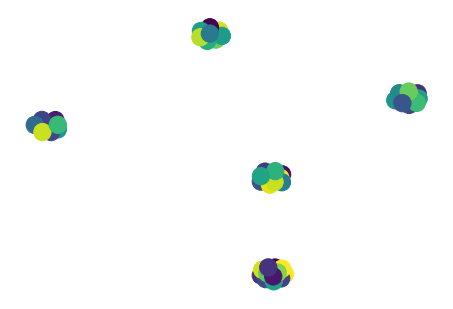

                        0         1
0    [0.5454701510335127]  0.363563
1   [0.17186531503221092]  0.726609
2    [0.8529318094853018]  0.527872
3    [0.1802234107934909]  0.511501
4    [0.5887000501236939]  0.303575
5   [0.12077490070210317]  0.494969
6    [0.5546987504607485]  0.369100
7   [0.08202617803816459]  0.838650
8    [0.9927051747471592]  0.847001
9   [0.25271926140483236]  0.645755
10   [0.5329600134943397]  0.292427
11   [0.8921390974896606]  0.567079
12   [0.2420936256921531]  0.449631
13    [0.417620739071376]  0.299405
14   [0.8679454838383429]  0.543346
15   [0.2863302410874564]  0.634346
16  [0.13769966369288933]  0.478044
17  [0.05079360233397934]  0.847681
18   [0.9282908716142158]  0.782587
19   [0.7799501422424319]  0.330805
20   [0.6944745088808787]  0.369875
21   [0.9534386673937157]  0.628379
22   [0.9319422792028977]  0.481248
23  [0.20739953724741955]  0.713277
24  [0.22335698243535906]  0.675118
25   [0.9975183649415177]  0.851814
26  [0.49206330478724125]  0

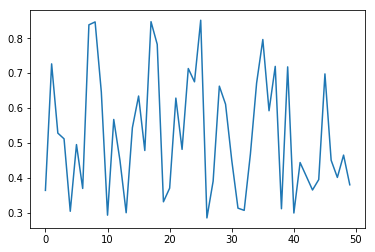

0.4796462308566474 0.030201231667091318
______NOOKS_________
DAY 0


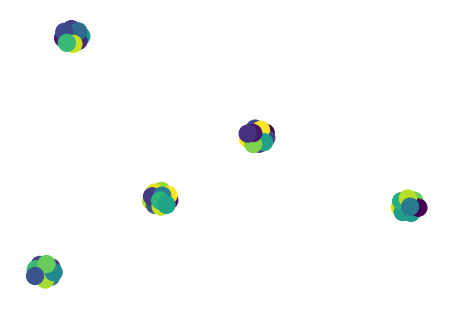

______NETWORK_________


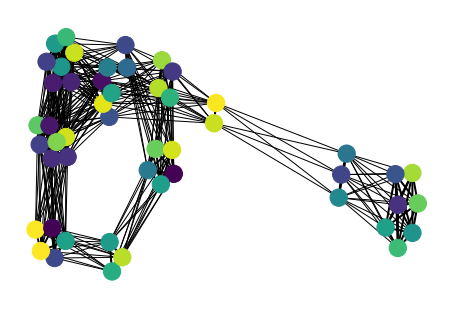

                        0         1
0    [0.5454701510335127]  0.333586
1   [0.17186531503221092]  0.421581
2    [0.8529318094853018]  0.492416
3    [0.1802234107934909]  0.511501
4    [0.5887000501236939]  0.255409
5   [0.12077490070210317]  0.465755
6    [0.5546987504607485]  0.335431
7   [0.08202617803816459]  0.573379
8    [0.9927051747471592]  0.597506
9   [0.25271926140483236]  0.538429
10   [0.5329600134943397]  0.266557
11   [0.8921390974896606]  0.523781
12   [0.2420936256921531]  0.494407
13    [0.417620739071376]  0.353985
14   [0.8679454838383429]  0.410475
15   [0.2863302410874564]  0.409936
16  [0.13769966369288933]  0.448830
17  [0.05079360233397934]  0.699970
18   [0.9282908716142158]  0.641427
19   [0.7799501422424319]  0.402530
20   [0.6944745088808787]  0.271698
21   [0.9534386673937157]  0.649458
22   [0.9319422792028977]  0.524124
23  [0.20739953724741955]  0.660958
24  [0.22335698243535906]  0.400984
25   [0.9975183649415177]  0.601357
26  [0.49206330478724125]  0

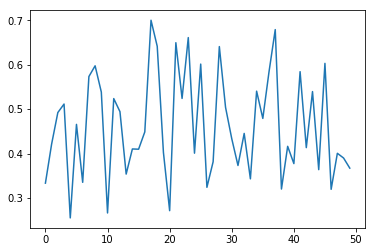

0.43944225110749935 0.01356451282600948
______NOOKS_________
DAY 1


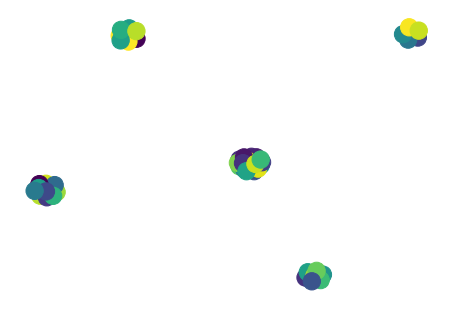

______NETWORK_________


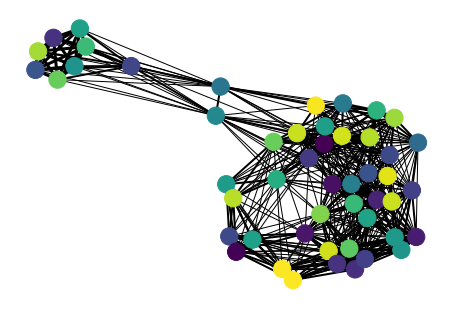

                        0         1
0    [0.5454701510335127]  0.319784
1   [0.17186531503221092]  0.445386
2    [0.8529318094853018]  0.462041
3    [0.1802234107934909]  0.511501
4    [0.5887000501236939]  0.255409
5   [0.12077490070210317]  0.620211
6    [0.5546987504607485]  0.323437
7   [0.08202617803816459]  0.745089
8    [0.9927051747471592]  0.669824
9   [0.25271926140483236]  0.531600
10   [0.5329600134943397]  0.266557
11   [0.8921390974896606]  0.684042
12   [0.2420936256921531]  0.449631
13    [0.417620739071376]  0.371084
14   [0.8679454838383429]  0.410475
15   [0.2863302410874564]  0.522915
16  [0.13769966369288933]  0.567129
17  [0.05079360233397934]  0.693140
18   [0.9282908716142158]  0.641427
19   [0.7799501422424319]  0.414917
20   [0.6944745088808787]  0.271698
21   [0.9534386673937157]  0.624704
22   [0.9319422792028977]  0.543609
23  [0.20739953724741955]  0.626260
24  [0.22335698243535906]  0.421336
25   [0.9975183649415177]  0.673674
26  [0.49206330478724125]  0

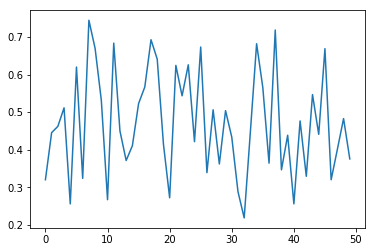

0.4489847542420373 0.01978437880620824
______NOOKS_________
DAY 2


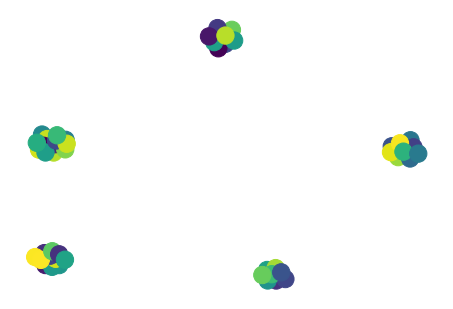

______NETWORK_________


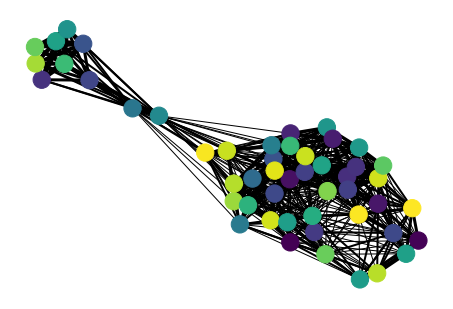

                        0         1
0    [0.5454701510335127]  0.273175
1   [0.17186531503221092]  0.444423
2    [0.8529318094853018]  0.423295
3    [0.1802234107934909]  0.511501
4    [0.5887000501236939]  0.255409
5   [0.12077490070210317]  0.449823
6    [0.5546987504607485]  0.269512
7   [0.08202617803816459]  0.559812
8    [0.9927051747471592]  0.669824
9   [0.25271926140483236]  0.538429
10   [0.5329600134943397]  0.266557
11   [0.8921390974896606]  0.575403
12   [0.2420936256921531]  0.449631
13    [0.417620739071376]  0.325462
14   [0.8679454838383429]  0.410475
15   [0.2863302410874564]  0.423499
16  [0.13769966369288933]  0.414253
17  [0.05079360233397934]  0.607805
18   [0.9282908716142158]  0.550889
19   [0.7799501422424319]  0.477578
20   [0.6944745088808787]  0.271698
21   [0.9534386673937157]  0.458753
22   [0.9319422792028977]  0.613868
23  [0.20739953724741955]  0.543626
24  [0.22335698243535906]  0.420373
25   [0.9975183649415177]  0.617528
26  [0.49206330478724125]  0

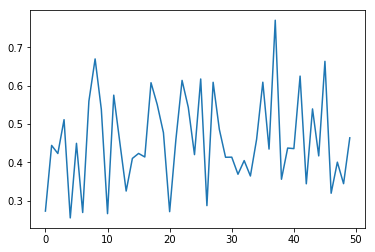

0.43678083773253007 0.014194886505533187
______NOOKS_________
DAY 3


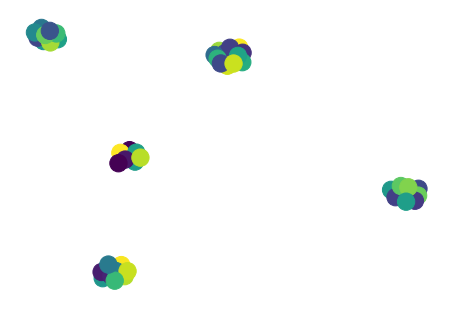

______NETWORK_________


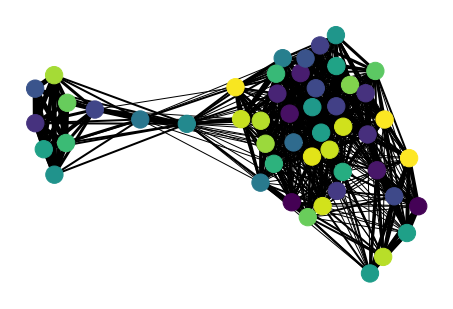

                        0         1
0    [0.5454701510335127]  0.345651
1   [0.17186531503221092]  0.497638
2    [0.8529318094853018]  0.487116
3    [0.1802234107934909]  0.451960
4    [0.5887000501236939]  0.303575
5   [0.12077490070210317]  0.449823
6    [0.5546987504607485]  0.376956
7   [0.08202617803816459]  0.745089
8    [0.9927051747471592]  0.631105
9   [0.25271926140483236]  0.446264
10   [0.5329600134943397]  0.266557
11   [0.8921390974896606]  0.575403
12   [0.2420936256921531]  0.426563
13    [0.417620739071376]  0.269613
14   [0.8679454838383429]  0.410475
15   [0.2863302410874564]  0.423499
16  [0.13769966369288933]  0.488591
17  [0.05079360233397934]  0.607805
18   [0.9282908716142158]  0.562834
19   [0.7799501422424319]  0.477578
20   [0.6944745088808787]  0.271698
21   [0.9534386673937157]  0.594967
22   [0.9319422792028977]  0.446298
23  [0.20739953724741955]  0.575968
24  [0.22335698243535906]  0.420373
25   [0.9975183649415177]  0.765525
26  [0.49206330478724125]  0

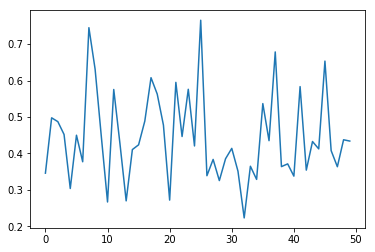

0.4250306264608906 0.014817776699542855
______NOOKS_________
DAY 4


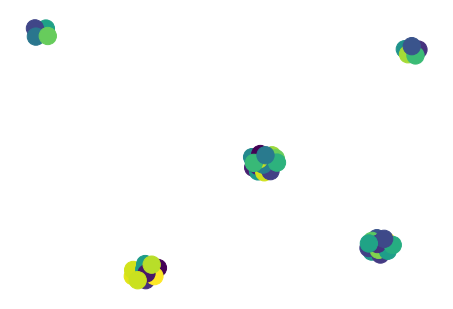

______NETWORK_________


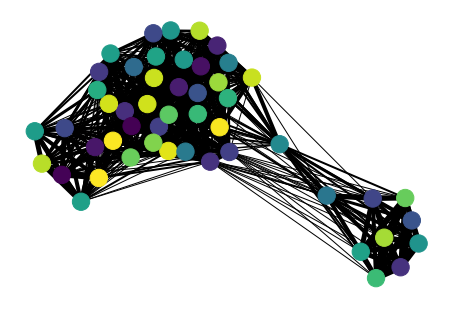

                        0         1
0    [0.5454701510335127]  0.313648
1   [0.17186531503221092]  0.347442
2    [0.8529318094853018]  0.522935
3    [0.1802234107934909]  0.451960
4    [0.5887000501236939]  0.303575
5   [0.12077490070210317]  0.449823
6    [0.5546987504607485]  0.379816
7   [0.08202617803816459]  0.677672
8    [0.9927051747471592]  0.587355
9   [0.25271926140483236]  0.465976
10   [0.5329600134943397]  0.266557
11   [0.8921390974896606]  0.575403
12   [0.2420936256921531]  0.426563
13    [0.417620739071376]  0.286141
14   [0.8679454838383429]  0.410475
15   [0.2863302410874564]  0.488825
16  [0.13769966369288933]  0.568605
17  [0.05079360233397934]  0.607805
18   [0.9282908716142158]  0.562834
19   [0.7799501422424319]  0.477578
20   [0.6944745088808787]  0.271698
21   [0.9534386673937157]  0.779838
22   [0.9319422792028977]  0.636376
23  [0.20739953724741955]  0.386954
24  [0.22335698243535906]  0.420373
25   [0.9975183649415177]  0.508553
26  [0.49206330478724125]  0

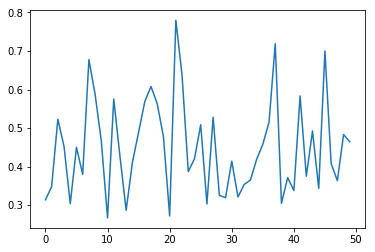

0.4234679232277486 0.015401520894629962
______NOOKS_________
DAY 5


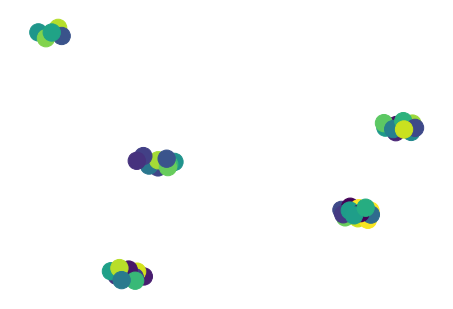

______NETWORK_________


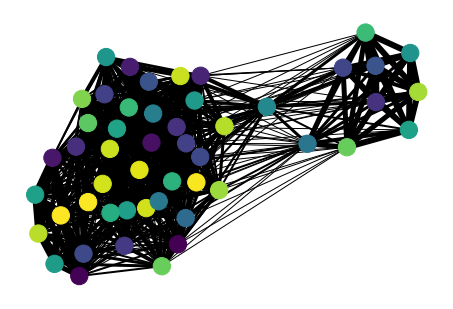

                        0         1
0    [0.5454701510335127]  0.297290
1   [0.17186531503221092]  0.355295
2    [0.8529318094853018]  0.429716
3    [0.1802234107934909]  0.451960
4    [0.5887000501236939]  0.255182
5   [0.12077490070210317]  0.309320
6    [0.5546987504607485]  0.379816
7   [0.08202617803816459]  0.677672
8    [0.9927051747471592]  0.669824
9   [0.25271926140483236]  0.531600
10   [0.5329600134943397]  0.229388
11   [0.8921390974896606]  0.575403
12   [0.2420936256921531]  0.313766
13    [0.417620739071376]  0.286141
14   [0.8679454838383429]  0.410475
15   [0.2863302410874564]  0.365598
16  [0.13769966369288933]  0.568605
17  [0.05079360233397934]  0.607805
18   [0.9282908716142158]  0.456597
19   [0.7799501422424319]  0.437921
20   [0.6944745088808787]  0.341019
21   [0.9534386673937157]  0.654407
22   [0.9319422792028977]  0.439327
23  [0.20739953724741955]  0.443697
24  [0.22335698243535906]  0.388371
25   [0.9975183649415177]  0.601357
26  [0.49206330478724125]  0

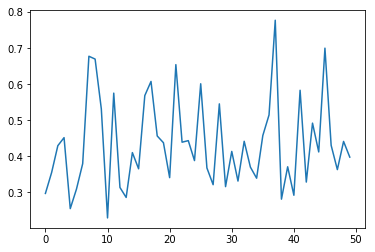

0.4130446924610365 0.015879334483863316
______NOOKS_________
DAY 6


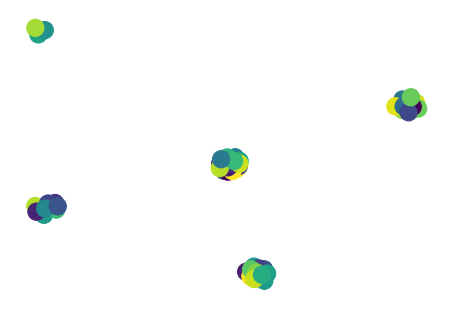

______NETWORK_________


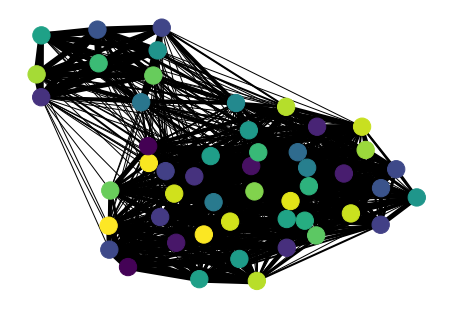

                        0         1
0    [0.5454701510335127]  0.265287
1   [0.17186531503221092]  0.340959
2    [0.8529318094853018]  0.429716
3    [0.1802234107934909]  0.451960
4    [0.5887000501236939]  0.233028
5   [0.12077490070210317]  0.326451
6    [0.5546987504607485]  0.379816
7   [0.08202617803816459]  0.644451
8    [0.9927051747471592]  0.577057
9   [0.25271926140483236]  0.412379
10   [0.5329600134943397]  0.229388
11   [0.8921390974896606]  0.611461
12   [0.2420936256921531]  0.311173
13    [0.417620739071376]  0.337934
14   [0.8679454838383429]  0.410475
15   [0.2863302410874564]  0.365598
16  [0.13769966369288933]  0.568605
17  [0.05079360233397934]  0.607805
18   [0.9282908716142158]  0.456597
19   [0.7799501422424319]  0.477578
20   [0.6944745088808787]  0.341019
21   [0.9534386673937157]  0.600439
22   [0.9319422792028977]  0.316989
23  [0.20739953724741955]  0.317957
24  [0.22335698243535906]  0.468559
25   [0.9975183649415177]  0.601357
26  [0.49206330478724125]  0

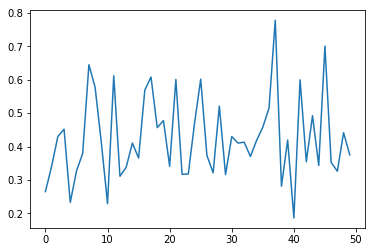

0.4114269020514093 0.015823313564380836
______NOOKS_________
DAY 7


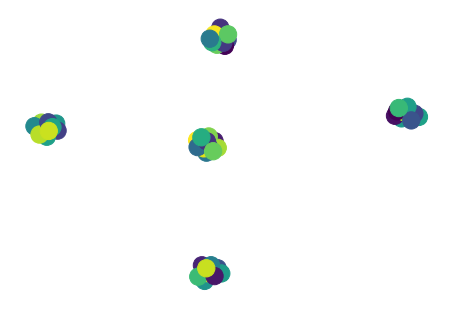

______NETWORK_________


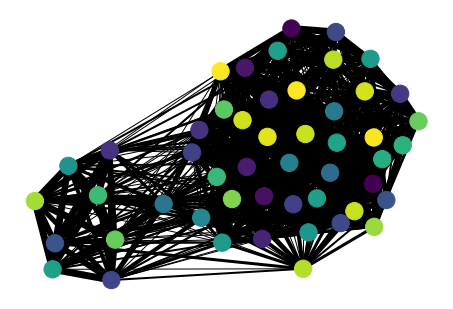

                        0         1
0    [0.5454701510335127]  0.308702
1   [0.17186531503221092]  0.483546
2    [0.8529318094853018]  0.429716
3    [0.1802234107934909]  0.451960
4    [0.5887000501236939]  0.233028
5   [0.12077490070210317]  0.472468
6    [0.5546987504607485]  0.405706
7   [0.08202617803816459]  0.571960
8    [0.9927051747471592]  0.552842
9   [0.25271926140483236]  0.369828
10   [0.5329600134943397]  0.229388
11   [0.8921390974896606]  0.611461
12   [0.2420936256921531]  0.401238
13    [0.417620739071376]  0.337934
14   [0.8679454838383429]  0.394462
15   [0.2863302410874564]  0.521876
16  [0.13769966369288933]  0.570288
17  [0.05079360233397934]  0.449377
18   [0.9282908716142158]  0.593767
19   [0.7799501422424319]  0.478051
20   [0.6944745088808787]  0.341019
21   [0.9534386673937157]  0.613856
22   [0.9319422792028977]  0.587769
23  [0.20739953724741955]  0.514178
24  [0.22335698243535906]  0.355838
25   [0.9975183649415177]  0.601829
26  [0.49206330478724125]  0

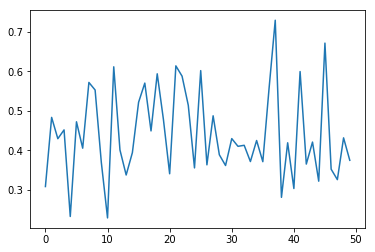

0.4202605956697034 0.012591988753326112
______NOOKS_________
DAY 8


______NETWORK_________


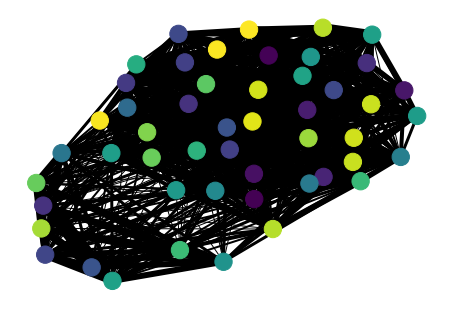

                        0         1
0    [0.5454701510335127]  0.306976
1   [0.17186531503221092]  0.705500
2    [0.8529318094853018]  0.378878
3    [0.1802234107934909]  0.451960
4    [0.5887000501236939]  0.233028
5   [0.12077490070210317]  0.404717
6    [0.5546987504607485]  0.357414
7   [0.08202617803816459]  0.485519
8    [0.9927051747471592]  0.552842
9   [0.25271926140483236]  0.439700
10   [0.5329600134943397]  0.229388
11   [0.8921390974896606]  0.643855
12   [0.2420936256921531]  0.401238
13    [0.417620739071376]  0.337934
14   [0.8679454838383429]  0.394462
15   [0.2863302410874564]  0.483355
16  [0.13769966369288933]  0.570288
17  [0.05079360233397934]  0.449377
18   [0.9282908716142158]  0.482449
19   [0.7799501422424319]  0.466166
20   [0.6944745088808787]  0.341019
21   [0.9534386673937157]  0.633550
22   [0.9319422792028977]  0.611984
23  [0.20739953724741955]  0.514178
24  [0.22335698243535906]  0.375758
25   [0.9975183649415177]  0.459100
26  [0.49206330478724125]  0

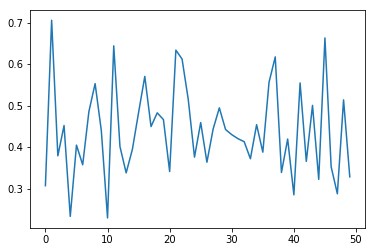

0.43480777444512175 0.011953045048539246
______NOOKS_________
DAY 9


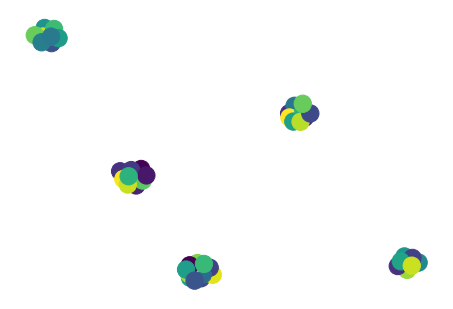

______NETWORK_________


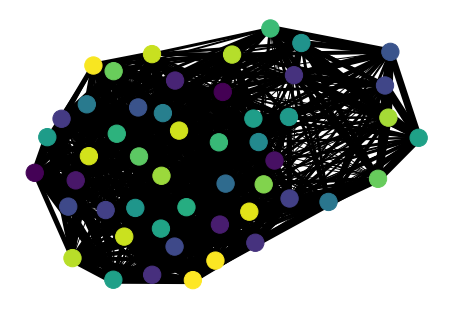

                        0         1
0    [0.5454701510335127]  0.308702
1   [0.17186531503221092]  0.626275
2    [0.8529318094853018]  0.296049
3    [0.1802234107934909]  0.345470
4    [0.5887000501236939]  0.233028
5   [0.12077490070210317]  0.650870
6    [0.5546987504607485]  0.274599
7   [0.08202617803816459]  0.432656
8    [0.9927051747471592]  0.552842
9   [0.25271926140483236]  0.481253
10   [0.5329600134943397]  0.229388
11   [0.8921390974896606]  0.653635
12   [0.2420936256921531]  0.323135
13    [0.417620739071376]  0.265840
14   [0.8679454838383429]  0.500951
15   [0.2863302410874564]  0.405873
16  [0.13769966369288933]  0.570288
17  [0.05079360233397934]  0.449377
18   [0.9282908716142158]  0.576501
19   [0.7799501422424319]  0.466166
20   [0.6944745088808787]  0.341019
21   [0.9534386673937157]  0.633550
22   [0.9319422792028977]  0.642126
23  [0.20739953724741955]  0.514178
24  [0.22335698243535906]  0.464322
25   [0.9975183649415177]  0.601829
26  [0.49206330478724125]  0

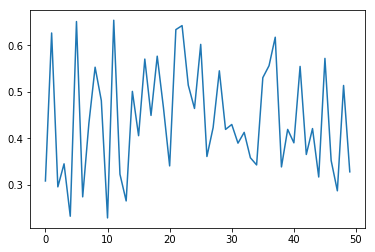

0.42225673213792825 0.01419901098949786
______NOOKS_________
DAY 10


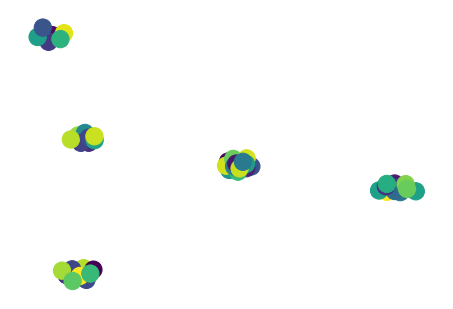

______NETWORK_________


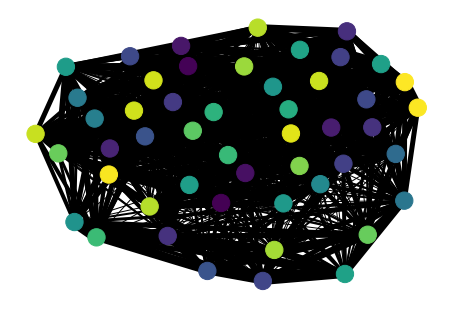

                        0         1
0    [0.5454701510335127]  0.306976
1   [0.17186531503221092]  0.626275
2    [0.8529318094853018]  0.408091
3    [0.1802234107934909]  0.345470
4    [0.5887000501236939]  0.256096
5   [0.12077490070210317]  0.568401
6    [0.5546987504607485]  0.277984
7   [0.08202617803816459]  0.520491
8    [0.9927051747471592]  0.523145
9   [0.25271926140483236]  0.450854
10   [0.5329600134943397]  0.229388
11   [0.8921390974896606]  0.570235
12   [0.2420936256921531]  0.323135
13    [0.417620739071376]  0.345752
14   [0.8679454838383429]  0.500951
15   [0.2863302410874564]  0.425452
16  [0.13769966369288933]  0.507979
17  [0.05079360233397934]  0.519249
18   [0.9282908716142158]  0.490835
19   [0.7799501422424319]  0.361735
20   [0.6944745088808787]  0.341019
21   [0.9534386673937157]  0.661080
22   [0.9319422792028977]  0.642126
23  [0.20739953724741955]  0.389436
24  [0.22335698243535906]  0.375758
25   [0.9975183649415177]  0.601829
26  [0.49206330478724125]  0

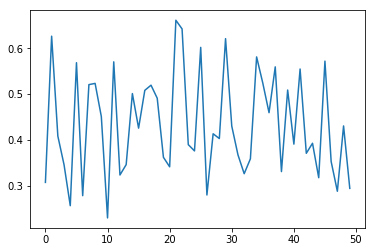

0.41061252541105575 0.012831093409069875
______NOOKS_________
DAY 11


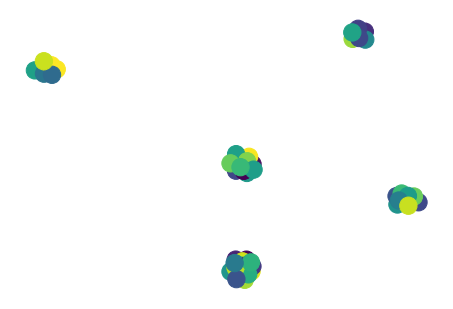

______NETWORK_________


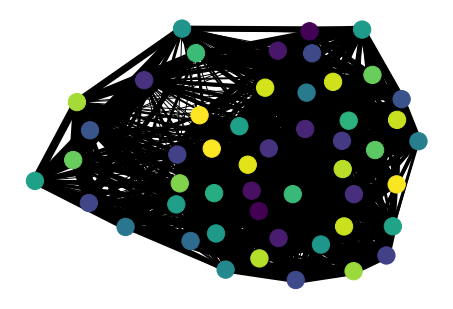

                        0         1
0    [0.5454701510335127]  0.306976
1   [0.17186531503221092]  0.471926
2    [0.8529318094853018]  0.382006
3    [0.1802234107934909]  0.451960
4    [0.5887000501236939]  0.256096
5   [0.12077490070210317]  0.249885
6    [0.5546987504607485]  0.277984
7   [0.08202617803816459]  0.520491
8    [0.9927051747471592]  0.512847
9   [0.25271926140483236]  0.402669
10   [0.5329600134943397]  0.298239
11   [0.8921390974896606]  0.521863
12   [0.2420936256921531]  0.323135
13    [0.417620739071376]  0.345752
14   [0.8679454838383429]  0.452635
15   [0.2863302410874564]  0.425452
16  [0.13769966369288933]  0.443325
17  [0.05079360233397934]  0.519249
18   [0.9282908716142158]  0.490835
19   [0.7799501422424319]  0.361735
20   [0.6944745088808787]  0.344241
21   [0.9534386673937157]  0.633550
22   [0.9319422792028977]  0.642126
23  [0.20739953724741955]  0.514178
24  [0.22335698243535906]  0.375758
25   [0.9975183649415177]  0.510789
26  [0.49206330478724125]  0

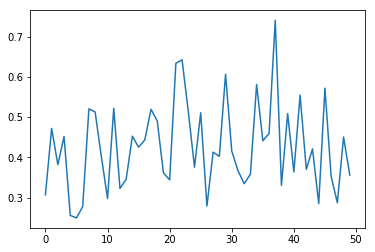

0.41447932944698895 0.011962975551395267
______NOOKS_________
DAY 12


______NETWORK_________


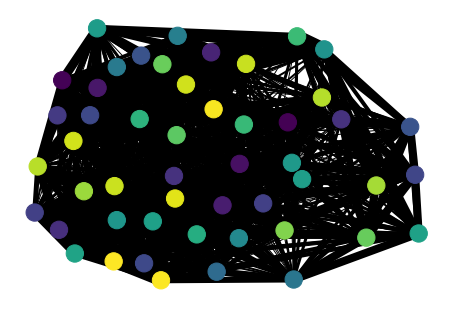

                        0         1
0    [0.5454701510335127]  0.292230
1   [0.17186531503221092]  0.708299
2    [0.8529318094853018]  0.388718
3    [0.1802234107934909]  0.451960
4    [0.5887000501236939]  0.256096
5   [0.12077490070210317]  0.415859
6    [0.5546987504607485]  0.319046
7   [0.08202617803816459]  0.504288
8    [0.9927051747471592]  0.523145
9   [0.25271926140483236]  0.402669
10   [0.5329600134943397]  0.234306
11   [0.8921390974896606]  0.521863
12   [0.2420936256921531]  0.440770
13    [0.417620739071376]  0.345752
14   [0.8679454838383429]  0.452635
15   [0.2863302410874564]  0.425452
16  [0.13769966369288933]  0.443325
17  [0.05079360233397934]  0.498574
18   [0.9282908716142158]  0.490835
19   [0.7799501422424319]  0.361735
20   [0.6944745088808787]  0.344241
21   [0.9534386673937157]  0.612550
22   [0.9319422792028977]  0.642126
23  [0.20739953724741955]  0.354366
24  [0.22335698243535906]  0.375758
25   [0.9975183649415177]  0.484848
26  [0.49206330478724125]  0

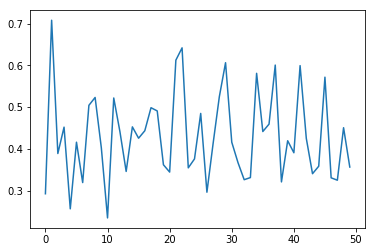

0.4176092926269176 0.011200889018280605
______NOOKS_________
DAY 13


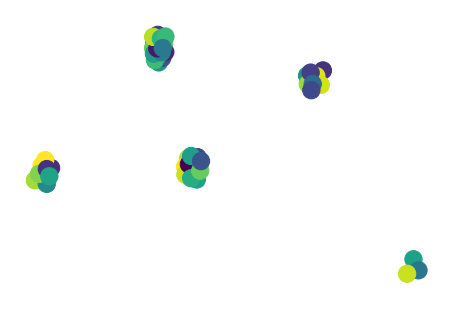

______NETWORK_________


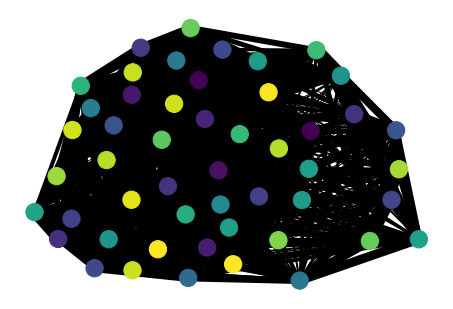

                        0         1
0    [0.5454701510335127]  0.290343
1   [0.17186531503221092]  0.708299
2    [0.8529318094853018]  0.388718
3    [0.1802234107934909]  0.531756
4    [0.5887000501236939]  0.256096
5   [0.12077490070210317]  0.459828
6    [0.5546987504607485]  0.277984
7   [0.08202617803816459]  0.504288
8    [0.9927051747471592]  0.523145
9   [0.25271926140483236]  0.285812
10   [0.5329600134943397]  0.234306
11   [0.8921390974896606]  0.521863
12   [0.2420936256921531]  0.440770
13    [0.417620739071376]  0.345752
14   [0.8679454838383429]  0.452635
15   [0.2863302410874564]  0.425452
16  [0.13769966369288933]  0.443325
17  [0.05079360233397934]  0.498574
18   [0.9282908716142158]  0.490835
19   [0.7799501422424319]  0.361735
20   [0.6944745088808787]  0.344241
21   [0.9534386673937157]  0.509640
22   [0.9319422792028977]  0.647561
23  [0.20739953724741955]  0.354366
24  [0.22335698243535906]  0.375758
25   [0.9975183649415177]  0.484848
26  [0.49206330478724125]  0

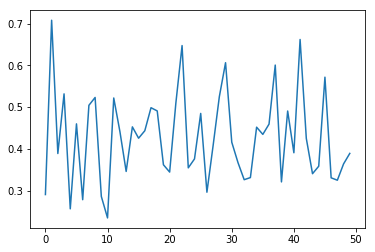

0.42042064691178904 0.011671591310974679
______NOOKS_________
DAY 14


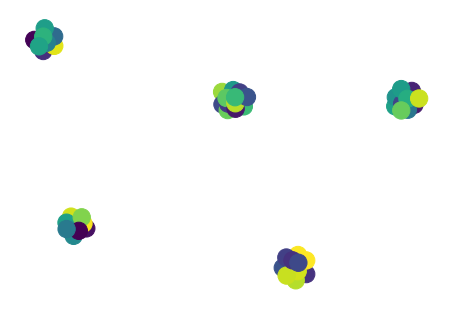

______NETWORK_________


                        0         1
0    [0.5454701510335127]  0.290343
1   [0.17186531503221092]  0.699483
2    [0.8529318094853018]  0.388718
3    [0.1802234107934909]  0.531756
4    [0.5887000501236939]  0.207702
5   [0.12077490070210317]  0.520005
6    [0.5546987504607485]  0.243940
7   [0.08202617803816459]  0.504288
8    [0.9927051747471592]  0.523145
9   [0.25271926140483236]  0.285812
10   [0.5329600134943397]  0.196128
11   [0.8921390974896606]  0.455372
12   [0.2420936256921531]  0.345867
13    [0.417620739071376]  0.193477
14   [0.8679454838383429]  0.394462
15   [0.2863302410874564]  0.425452
16  [0.13769966369288933]  0.469867
17  [0.05079360233397934]  0.498574
18   [0.9282908716142158]  0.483697
19   [0.7799501422424319]  0.361735
20   [0.6944745088808787]  0.415972
21   [0.9534386673937157]  0.509640
22   [0.9319422792028977]  0.642126
23  [0.20739953724741955]  0.467953
24  [0.22335698243535906]  0.411808
25   [0.9975183649415177]  0.567316
26  [0.49206330478724125]  0

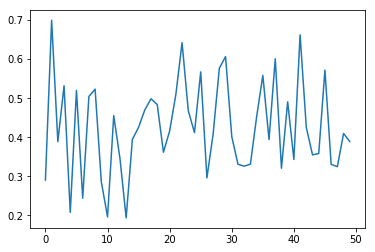

0.41077154682059835 0.01433831416419332
______NOOKS_________
DAY 15


______NETWORK_________


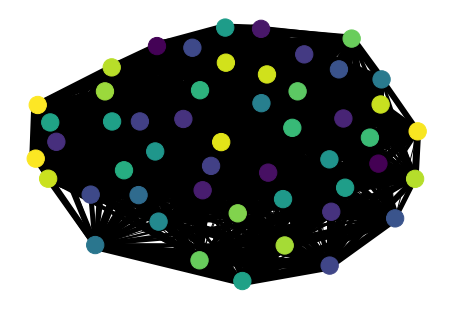

                        0         1
0    [0.5454701510335127]  0.266896
1   [0.17186531503221092]  0.699483
2    [0.8529318094853018]  0.430109
3    [0.1802234107934909]  0.425267
4    [0.5887000501236939]  0.207702
5   [0.12077490070210317]  0.521003
6    [0.5546987504607485]  0.243940
7   [0.08202617803816459]  0.473592
8    [0.9927051747471592]  0.523145
9   [0.25271926140483236]  0.285812
10   [0.5329600134943397]  0.196128
11   [0.8921390974896606]  0.465577
12   [0.2420936256921531]  0.345867
13    [0.417620739071376]  0.193477
14   [0.8679454838383429]  0.394462
15   [0.2863302410874564]  0.428990
16  [0.13769966369288933]  0.469867
17  [0.05079360233397934]  0.450857
18   [0.9282908716142158]  0.487625
19   [0.7799501422424319]  0.361735
20   [0.6944745088808787]  0.415972
21   [0.9534386673937157]  0.509640
22   [0.9319422792028977]  0.642126
23  [0.20739953724741955]  0.467953
24  [0.22335698243535906]  0.411808
25   [0.9975183649415177]  0.567316
26  [0.49206330478724125]  0

0.41794362166839716 0.01385928039500621
______NOOKS_________
DAY 16


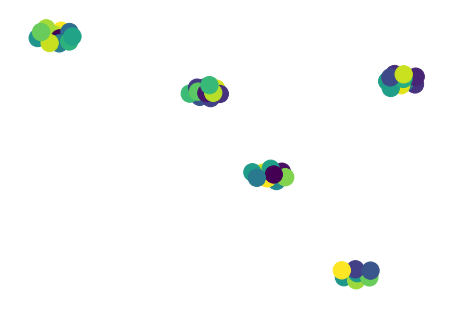

______NETWORK_________


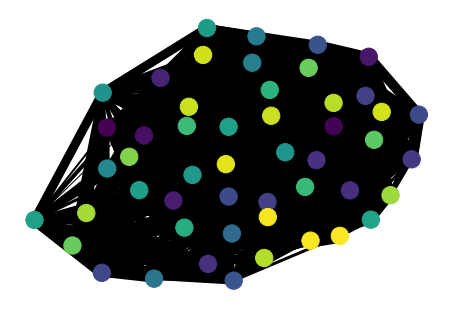

                        0         1
0    [0.5454701510335127]  0.266896
1   [0.17186531503221092]  0.699483
2    [0.8529318094853018]  0.430109
3    [0.1802234107934909]  0.425267
4    [0.5887000501236939]  0.207702
5   [0.12077490070210317]  0.520005
6    [0.5546987504607485]  0.307458
7   [0.08202617803816459]  0.458618
8    [0.9927051747471592]  0.523145
9   [0.25271926140483236]  0.373712
10   [0.5329600134943397]  0.196128
11   [0.8921390974896606]  0.465577
12   [0.2420936256921531]  0.345867
13    [0.417620739071376]  0.284773
14   [0.8679454838383429]  0.394462
15   [0.2863302410874564]  0.428990
16  [0.13769966369288933]  0.463253
17  [0.05079360233397934]  0.450857
18   [0.9282908716142158]  0.487625
19   [0.7799501422424319]  0.361735
20   [0.6944745088808787]  0.415972
21   [0.9534386673937157]  0.509640
22   [0.9319422792028977]  0.696753
23  [0.20739953724741955]  0.467953
24  [0.22335698243535906]  0.411808
25   [0.9975183649415177]  0.422861
26  [0.49206330478724125]  0

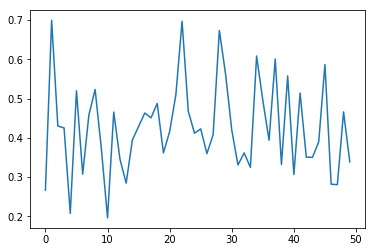

0.41794362166839716 0.013468426723410719
______NOOKS_________
DAY 17


______NETWORK_________


                        0         1
0    [0.5454701510335127]  0.308503
1   [0.17186531503221092]  0.720158
2    [0.8529318094853018]  0.430109
3    [0.1802234107934909]  0.393786
4    [0.5887000501236939]  0.207702
5   [0.12077490070210317]  0.520488
6    [0.5546987504607485]  0.307458
7   [0.08202617803816459]  0.530463
8    [0.9927051747471592]  0.605614
9   [0.25271926140483236]  0.373712
10   [0.5329600134943397]  0.196128
11   [0.8921390974896606]  0.465577
12   [0.2420936256921531]  0.289781
13    [0.417620739071376]  0.284773
14   [0.8679454838383429]  0.394462
15   [0.2863302410874564]  0.394217
16  [0.13769966369288933]  0.463253
17  [0.05079360233397934]  0.450857
18   [0.9282908716142158]  0.487625
19   [0.7799501422424319]  0.361735
20   [0.6944745088808787]  0.415972
21   [0.9534386673937157]  0.543424
22   [0.9319422792028977]  0.773259
23  [0.20739953724741955]  0.467953
24  [0.22335698243535906]  0.476236
25   [0.9975183649415177]  0.567316
26  [0.49206330478724125]  0

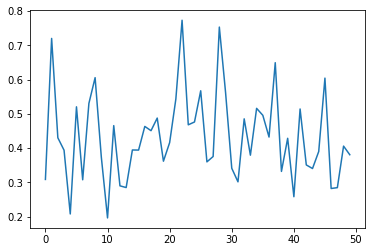

0.41085527854870074 0.01674540209655172
______NOOKS_________
DAY 18


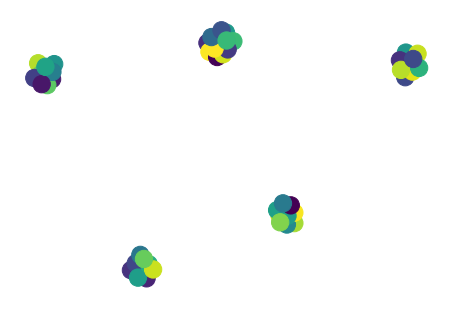

______NETWORK_________


                        0         1
0    [0.5454701510335127]  0.308503
1   [0.17186531503221092]  0.720158
2    [0.8529318094853018]  0.430109
3    [0.1802234107934909]  0.463108
4    [0.5887000501236939]  0.207702
5   [0.12077490070210317]  0.520488
6    [0.5546987504607485]  0.307458
7   [0.08202617803816459]  0.530463
8    [0.9927051747471592]  0.605614
9   [0.25271926140483236]  0.404110
10   [0.5329600134943397]  0.237830
11   [0.8921390974896606]  0.465577
12   [0.2420936256921531]  0.289781
13    [0.417620739071376]  0.284773
14   [0.8679454838383429]  0.394462
15   [0.2863302410874564]  0.317653
16  [0.13769966369288933]  0.619163
17  [0.05079360233397934]  0.450857
18   [0.9282908716142158]  0.457065
19   [0.7799501422424319]  0.454539
20   [0.6944745088808787]  0.415972
21   [0.9534386673937157]  0.543424
22   [0.9319422792028977]  0.604589
23  [0.20739953724741955]  0.467953
24  [0.22335698243535906]  0.476236
25   [0.9975183649415177]  0.422861
26  [0.49206330478724125]  0

0.41941620514518774 0.015278296726780187
______NOOKS_________
DAY 19


______NETWORK_________


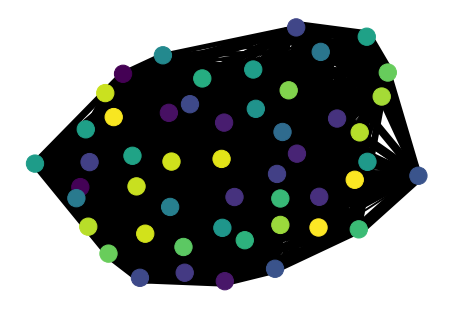

                        0         1
0    [0.5454701510335127]  0.337420
1   [0.17186531503221092]  0.571500
2    [0.8529318094853018]  0.515052
3    [0.1802234107934909]  0.372632
4    [0.5887000501236939]  0.233549
5   [0.12077490070210317]  0.520488
6    [0.5546987504607485]  0.285020
7   [0.08202617803816459]  0.530463
8    [0.9927051747471592]  0.605614
9   [0.25271926140483236]  0.404110
10   [0.5329600134943397]  0.237830
11   [0.8921390974896606]  0.465577
12   [0.2420936256921531]  0.289781
13    [0.417620739071376]  0.284773
14   [0.8679454838383429]  0.394462
15   [0.2863302410874564]  0.424879
16  [0.13769966369288933]  0.619163
17  [0.05079360233397934]  0.463010
18   [0.9282908716142158]  0.408573
19   [0.7799501422424319]  0.402308
20   [0.6944745088808787]  0.330216
21   [0.9534386673937157]  0.648658
22   [0.9319422792028977]  0.604589
23  [0.20739953724741955]  0.467953
24  [0.22335698243535906]  0.476236
25   [0.9975183649415177]  0.551146
26  [0.49206330478724125]  0

0.407958686351737 0.013376528509054457
______NOOKS_________
DAY 20


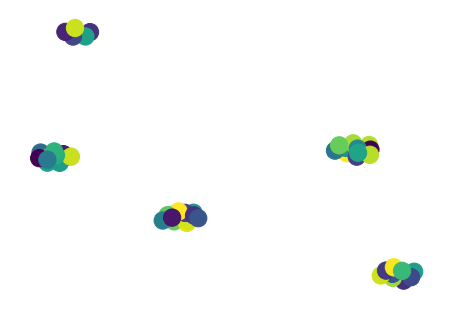

______NETWORK_________


                        0         1
0    [0.5454701510335127]  0.257232
1   [0.17186531503221092]  0.571500
2    [0.8529318094853018]  0.579475
3    [0.1802234107934909]  0.372632
4    [0.5887000501236939]  0.207702
5   [0.12077490070210317]  0.520488
6    [0.5546987504607485]  0.285020
7   [0.08202617803816459]  0.530463
8    [0.9927051747471592]  0.605614
9   [0.25271926140483236]  0.404110
10   [0.5329600134943397]  0.237830
11   [0.8921390974896606]  0.396857
12   [0.2420936256921531]  0.289781
13    [0.417620739071376]  0.284773
14   [0.8679454838383429]  0.394462
15   [0.2863302410874564]  0.424879
16  [0.13769966369288933]  0.633098
17  [0.05079360233397934]  0.450857
18   [0.9282908716142158]  0.408573
19   [0.7799501422424319]  0.402308
20   [0.6944745088808787]  0.330216
21   [0.9534386673937157]  0.580187
22   [0.9319422792028977]  0.773259
23  [0.20739953724741955]  0.467953
24  [0.22335698243535906]  0.476236
25   [0.9975183649415177]  0.551146
26  [0.49206330478724125]  0

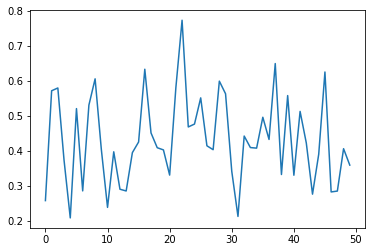

0.40877820988527286 0.01596858246240086
______NOOKS_________
DAY 21


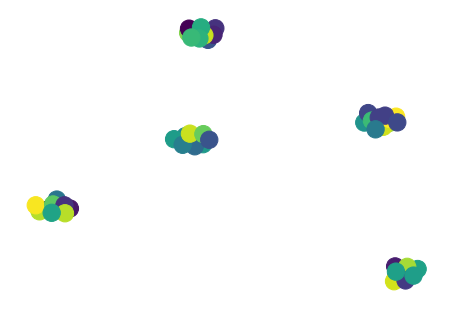

______NETWORK_________


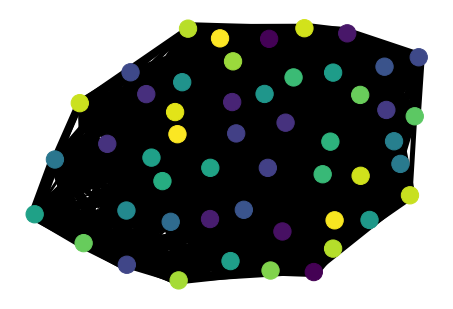

                        0         1
0    [0.5454701510335127]  0.295814
1   [0.17186531503221092]  0.571500
2    [0.8529318094853018]  0.568793
3    [0.1802234107934909]  0.372632
4    [0.5887000501236939]  0.207702
5   [0.12077490070210317]  0.520488
6    [0.5546987504607485]  0.285020
7   [0.08202617803816459]  0.530463
8    [0.9927051747471592]  0.605614
9   [0.25271926140483236]  0.404110
10   [0.5329600134943397]  0.237830
11   [0.8921390974896606]  0.293946
12   [0.2420936256921531]  0.289781
13    [0.417620739071376]  0.299338
14   [0.8679454838383429]  0.394462
15   [0.2863302410874564]  0.453151
16  [0.13769966369288933]  0.633098
17  [0.05079360233397934]  0.441793
18   [0.9282908716142158]  0.457065
19   [0.7799501422424319]  0.402308
20   [0.6944745088808787]  0.330216
21   [0.9534386673937157]  0.580187
22   [0.9319422792028977]  0.773259
23  [0.20739953724741955]  0.409642
24  [0.22335698243535906]  0.476236
25   [0.9975183649415177]  0.505004
26  [0.49206330478724125]  0

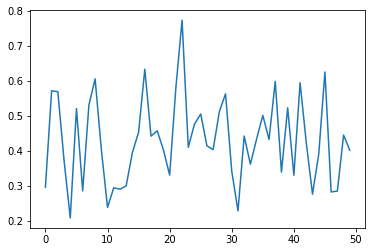

0.418055011548822 0.015005621794976142
______NOOKS_________
DAY 22


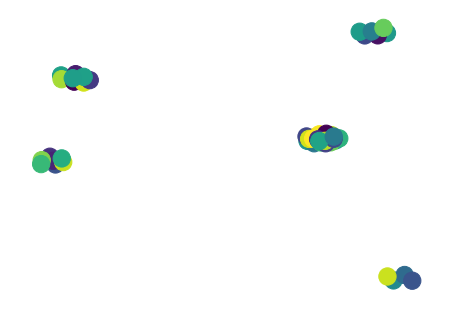

______NETWORK_________


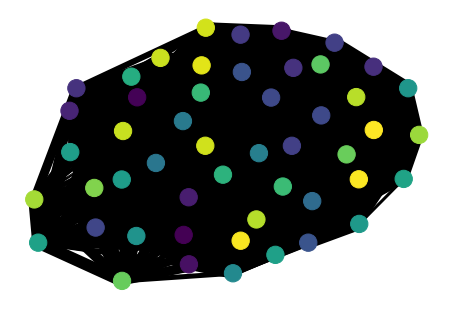

                        0         1
0    [0.5454701510335127]  0.247628
1   [0.17186531503221092]  0.720158
2    [0.8529318094853018]  0.568793
3    [0.1802234107934909]  0.262273
4    [0.5887000501236939]  0.207702
5   [0.12077490070210317]  0.520488
6    [0.5546987504607485]  0.307458
7   [0.08202617803816459]  0.512359
8    [0.9927051747471592]  0.605614
9   [0.25271926140483236]  0.417225
10   [0.5329600134943397]  0.237830
11   [0.8921390974896606]  0.443630
12   [0.2420936256921531]  0.358847
13    [0.417620739071376]  0.299338
14   [0.8679454838383429]  0.394462
15   [0.2863302410874564]  0.453151
16  [0.13769966369288933]  0.584806
17  [0.05079360233397934]  0.445105
18   [0.9282908716142158]  0.457065
19   [0.7799501422424319]  0.402308
20   [0.6944745088808787]  0.295351
21   [0.9534386673937157]  0.580187
22   [0.9319422792028977]  0.773259
23  [0.20739953724741955]  0.409642
24  [0.22335698243535906]  0.476236
25   [0.9975183649415177]  0.633289
26  [0.49206330478724125]  0

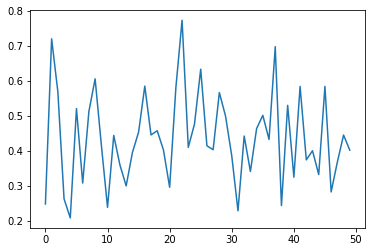

0.4247217047290488 0.01717895300326296
______NOOKS_________
DAY 23


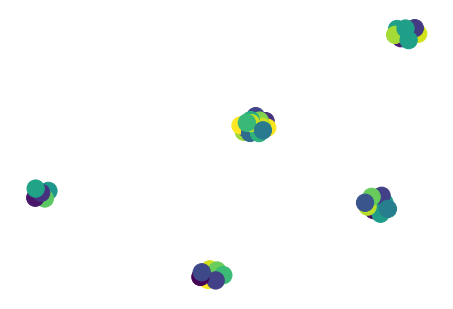

______NETWORK_________


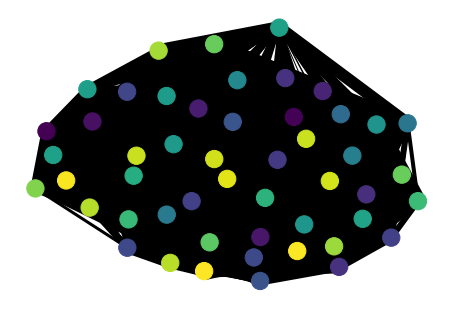

                        0         1
0    [0.5454701510335127]  0.278072
1   [0.17186531503221092]  0.720158
2    [0.8529318094853018]  0.603519
3    [0.1802234107934909]  0.262273
4    [0.5887000501236939]  0.207702
5   [0.12077490070210317]  0.440685
6    [0.5546987504607485]  0.307458
7   [0.08202617803816459]  0.512359
8    [0.9927051747471592]  0.629138
9   [0.25271926140483236]  0.417225
10   [0.5329600134943397]  0.276080
11   [0.8921390974896606]  0.414907
12   [0.2420936256921531]  0.281464
13    [0.417620739071376]  0.291485
14   [0.8679454838383429]  0.394462
15   [0.2863302410874564]  0.401248
16  [0.13769966369288933]  0.584806
17  [0.05079360233397934]  0.445105
18   [0.9282908716142158]  0.457065
19   [0.7799501422424319]  0.408181
20   [0.6944745088808787]  0.295351
21   [0.9534386673937157]  0.634155
22   [0.9319422792028977]  0.773259
23  [0.20739953724741955]  0.409642
24  [0.22335698243535906]  0.494860
25   [0.9975183649415177]  0.505004
26  [0.49206330478724125]  0

0.41132325346705073 0.01677787174528776
______NOOKS_________
DAY 24


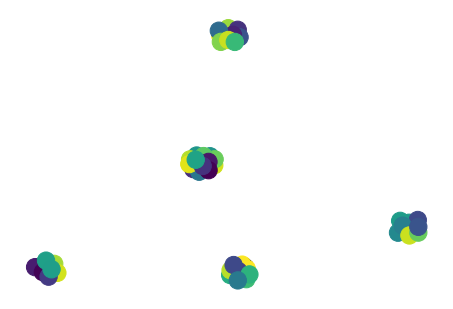

______NETWORK_________


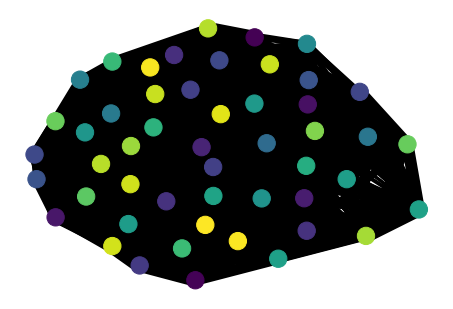

                        0         1
0    [0.5454701510335127]  0.278072
1   [0.17186531503221092]  0.720158
2    [0.8529318094853018]  0.536218
3    [0.1802234107934909]  0.387505
4    [0.5887000501236939]  0.199385
5   [0.12077490070210317]  0.639522
6    [0.5546987504607485]  0.260317
7   [0.08202617803816459]  0.512359
8    [0.9927051747471592]  0.629138
9   [0.25271926140483236]  0.417225
10   [0.5329600134943397]  0.276080
11   [0.8921390974896606]  0.414907
12   [0.2420936256921531]  0.281464
13    [0.417620739071376]  0.291485
14   [0.8679454838383429]  0.442502
15   [0.2863302410874564]  0.354485
16  [0.13769966369288933]  0.530258
17  [0.05079360233397934]  0.428902
18   [0.9282908716142158]  0.457065
19   [0.7799501422424319]  0.343069
20   [0.6944745088808787]  0.330216
21   [0.9534386673937157]  0.634155
22   [0.9319422792028977]  0.773259
23  [0.20739953724741955]  0.368562
24  [0.22335698243535906]  0.494860
25   [0.9975183649415177]  0.505004
26  [0.49206330478724125]  0

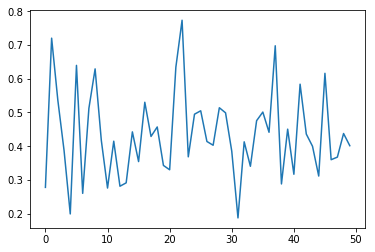

0.41606625680086406 0.01681949330313221
______NOOKS_________
DAY 25


______NETWORK_________


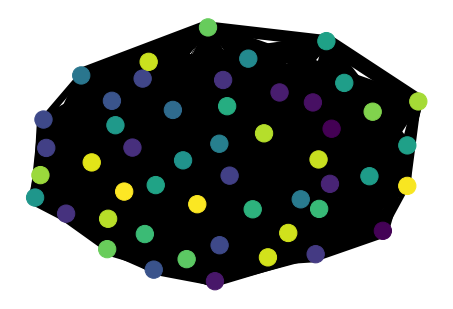

                        0         1
0    [0.5454701510335127]  0.270973
1   [0.17186531503221092]  0.720158
2    [0.8529318094853018]  0.536218
3    [0.1802234107934909]  0.387505
4    [0.5887000501236939]  0.199385
5   [0.12077490070210317]  0.599524
6    [0.5546987504607485]  0.260317
7   [0.08202617803816459]  0.405409
8    [0.9927051747471592]  0.629138
9   [0.25271926140483236]  0.417225
10   [0.5329600134943397]  0.276080
11   [0.8921390974896606]  0.497739
12   [0.2420936256921531]  0.281464
13    [0.417620739071376]  0.348320
14   [0.8679454838383429]  0.363637
15   [0.2863302410874564]  0.354485
16  [0.13769966369288933]  0.530258
17  [0.05079360233397934]  0.428902
18   [0.9282908716142158]  0.457065
19   [0.7799501422424319]  0.343069
20   [0.6944745088808787]  0.295351
21   [0.9534386673937157]  0.634155
22   [0.9319422792028977]  0.773259
23  [0.20739953724741955]  0.368562
24  [0.22335698243535906]  0.494860
25   [0.9975183649415177]  0.633289
26  [0.49206330478724125]  0

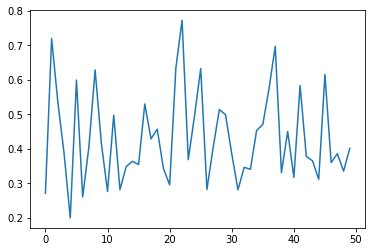

0.3945207479942165 0.017466146977031256
______NOOKS_________
DAY 26


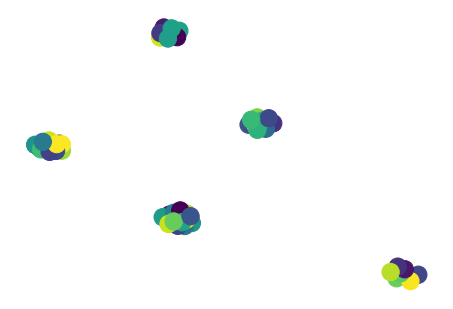

______NETWORK_________


                        0         1
0    [0.5454701510335127]  0.286998
1   [0.17186531503221092]  0.720158
2    [0.8529318094853018]  0.536218
3    [0.1802234107934909]  0.400877
4    [0.5887000501236939]  0.199385
5   [0.12077490070210317]  0.599524
6    [0.5546987504607485]  0.277859
7   [0.08202617803816459]  0.405409
8    [0.9927051747471592]  0.629138
9   [0.25271926140483236]  0.417225
10   [0.5329600134943397]  0.285937
11   [0.8921390974896606]  0.483627
12   [0.2420936256921531]  0.281464
13    [0.417620739071376]  0.348320
14   [0.8679454838383429]  0.494390
15   [0.2863302410874564]  0.455499
16  [0.13769966369288933]  0.530258
17  [0.05079360233397934]  0.582090
18   [0.9282908716142158]  0.457065
19   [0.7799501422424319]  0.343069
20   [0.6944745088808787]  0.189281
21   [0.9534386673937157]  0.659725
22   [0.9319422792028977]  0.773259
23  [0.20739953724741955]  0.368562
24  [0.22335698243535906]  0.393840
25   [0.9975183649415177]  0.505004
26  [0.49206330478724125]  0

0.41131714305168354 0.017111211567269836
______NOOKS_________
DAY 27


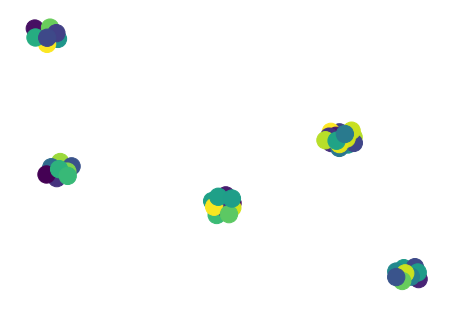

In [38]:
np.random.seed(SEED)
member_vectors = np.random.random(size=(50, 1))
#print(sorted(member_vectors))
exp = NooksExperiment(member_vectors, alpha=1000, swipe_mode="all")
exp.run(num_nooks=5)



______NETWORK_________


                        0         1
0    [0.5454701510335127]  0.286663
1   [0.17186531503221092]  0.715500
2    [0.8529318094853018]  0.594941
3    [0.1802234107934909]  0.328927
4    [0.5887000501236939]  0.395605
5   [0.12077490070210317]  0.516511
6    [0.5546987504607485]  0.338441
7   [0.08202617803816459]  0.622349
8    [0.9927051747471592]  0.734715
9   [0.25271926140483236]  0.699113
10   [0.5329600134943397]  0.325398
11   [0.8921390974896606]  0.620879
12   [0.2420936256921531]  0.287936
13    [0.417620739071376]  0.239634
14   [0.8679454838383429]  0.550599
15   [0.2863302410874564]  0.601035
16  [0.13769966369288933]  0.371451
17  [0.05079360233397934]  0.901039
18   [0.9282908716142158]  0.670301
19   [0.7799501422424319]  0.508690
20   [0.6944745088808787]  0.400637
21   [0.9534386673937157]  0.682178
22   [0.9319422792028977]  0.614596
23  [0.20739953724741955]  0.679966
24  [0.22335698243535906]  0.728475
25   [0.9975183649415177]  0.739528
26  [0.49206330478724125]  0

0.5103370797520406 0.027561071374917076
______NOOKS_________
DAY 0


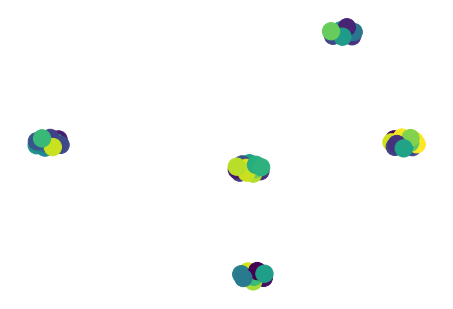

______NETWORK_________


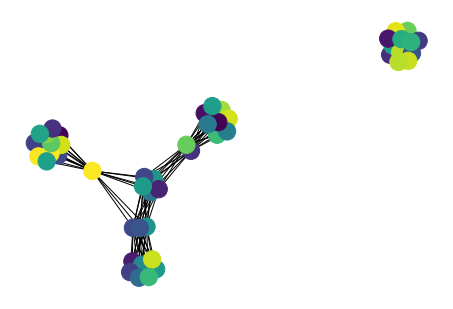

                        0         1
0    [0.5454701510335127]  0.261358
1   [0.17186531503221092]  0.715500
2    [0.8529318094853018]  0.594941
3    [0.1802234107934909]  0.588467
4    [0.5887000501236939]  0.395605
5   [0.12077490070210317]  0.484288
6    [0.5546987504607485]  0.288603
7   [0.08202617803816459]  0.622349
8    [0.9927051747471592]  0.825817
9   [0.25271926140483236]  0.664026
10   [0.5329600134943397]  0.357578
11   [0.8921390974896606]  0.620879
12   [0.2420936256921531]  0.331569
13    [0.417620739071376]  0.261358
14   [0.8679454838383429]  0.550599
15   [0.2863302410874564]  0.601035
16  [0.13769966369288933]  0.415084
17  [0.05079360233397934]  0.865952
18   [0.9282908716142158]  0.670301
19   [0.7799501422424319]  0.508690
20   [0.6944745088808787]  0.400637
21   [0.9534386673937157]  0.682178
22   [0.9319422792028977]  0.614596
23  [0.20739953724741955]  0.679966
24  [0.22335698243535906]  0.693388
25   [0.9975183649415177]  0.739528
26  [0.49206330478724125]  0

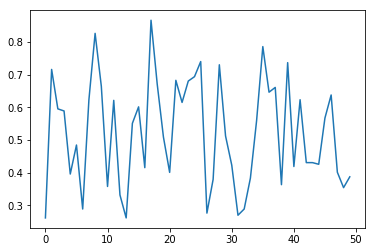

0.5312918255154306 0.026627225001588966
______NOOKS_________
DAY 1


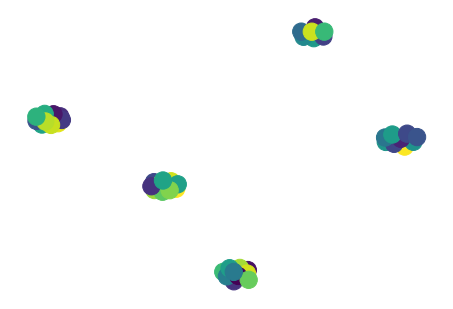

______NETWORK_________


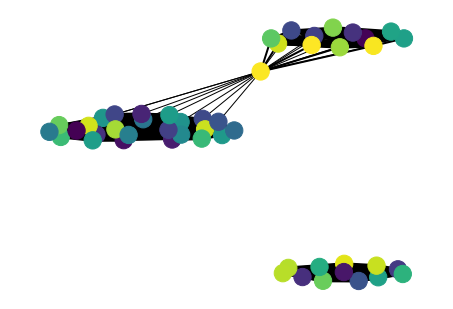

                        0         1
0    [0.5454701510335127]  0.244960
1   [0.17186531503221092]  0.715500
2    [0.8529318094853018]  0.250642
3    [0.1802234107934909]  0.588467
4    [0.5887000501236939]  0.395605
5   [0.12077490070210317]  0.484288
6    [0.5546987504607485]  0.288603
7   [0.08202617803816459]  0.622349
8    [0.9927051747471592]  0.090021
9   [0.25271926140483236]  0.275634
10   [0.5329600134943397]  0.343013
11   [0.8921390974896606]  0.620879
12   [0.2420936256921531]  0.287936
13    [0.417620739071376]  0.217725
14   [0.8679454838383429]  0.550599
15   [0.2863302410874564]  0.601035
16  [0.13769966369288933]  0.371451
17  [0.05079360233397934]  0.396542
18   [0.9282908716142158]  0.250642
19   [0.7799501422424319]  0.508690
20   [0.6944745088808787]  0.400637
21   [0.9534386673937157]  0.682178
22   [0.9319422792028977]  0.614596
23  [0.20739953724741955]  0.679966
24  [0.22335698243535906]  0.275634
25   [0.9975183649415177]  0.282254
26  [0.49206330478724125]  0

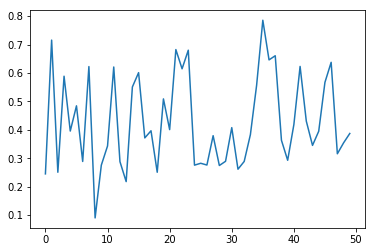

0.39097747384590575 0.025816524789763692
______NOOKS_________
DAY 2


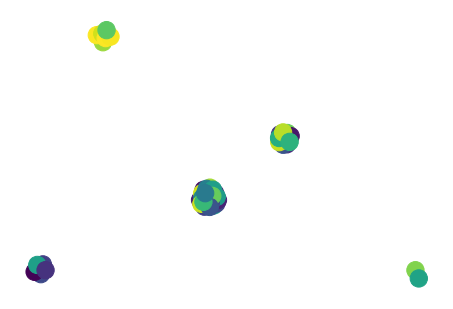

______NETWORK_________


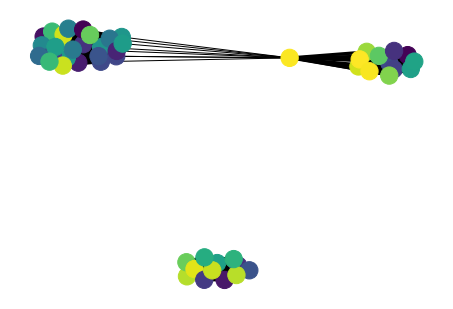

                        0         1
0    [0.5454701510335127]  0.217725
1   [0.17186531503221092]  0.503769
2    [0.8529318094853018]  0.250642
3    [0.1802234107934909]  0.398267
4    [0.5887000501236939]  0.375216
5   [0.12077490070210317]  0.431030
6    [0.5546987504607485]  0.288603
7   [0.08202617803816459]  0.531475
8    [0.9927051747471592]  0.090021
9   [0.25271926140483236]  0.275634
10   [0.5329600134943397]  0.142001
11   [0.8921390974896606]  0.373703
12   [0.2420936256921531]  0.193820
13    [0.417620739071376]  0.217725
14   [0.8679454838383429]  0.605147
15   [0.2863302410874564]  0.426169
16  [0.13769966369288933]  0.274742
17  [0.05079360233397934]  0.396542
18   [0.9282908716142158]  0.250642
19   [0.7799501422424319]  0.328828
20   [0.6944745088808787]  0.400637
21   [0.9534386673937157]  0.592546
22   [0.9319422792028977]  0.590611
23  [0.20739953724741955]  0.628278
24  [0.22335698243535906]  0.275634
25   [0.9975183649415177]  0.282254
26  [0.49206330478724125]  0

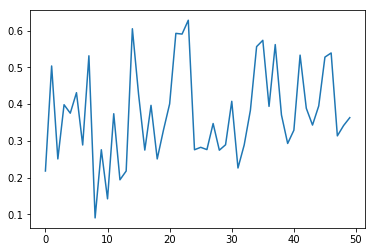

0.3667366715701692 0.016270094290534984
______NOOKS_________
DAY 3


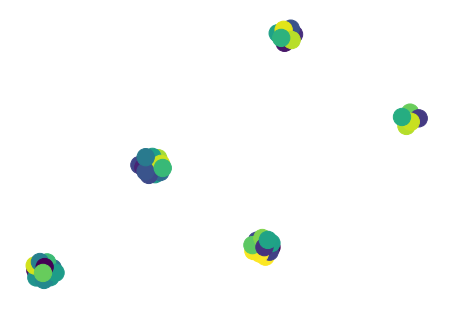

______NETWORK_________


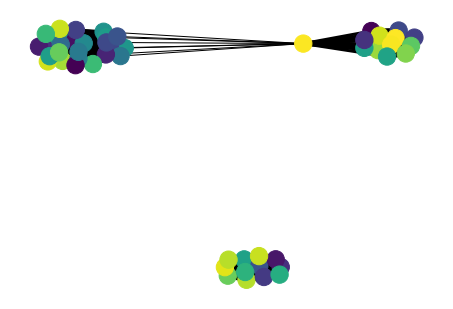

                        0         1
0    [0.5454701510335127]  0.268504
1   [0.17186531503221092]  0.503769
2    [0.8529318094853018]  0.250642
3    [0.1802234107934909]  0.633548
4    [0.5887000501236939]  0.375216
5   [0.12077490070210317]  0.431030
6    [0.5546987504607485]  0.288603
7   [0.08202617803816459]  0.595791
8    [0.9927051747471592]  0.090021
9   [0.25271926140483236]  0.275634
10   [0.5329600134943397]  0.267933
11   [0.8921390974896606]  0.373703
12   [0.2420936256921531]  0.243530
13    [0.417620739071376]  0.268504
14   [0.8679454838383429]  0.502297
15   [0.2863302410874564]  0.426169
16  [0.13769966369288933]  0.327045
17  [0.05079360233397934]  0.396542
18   [0.9282908716142158]  0.250642
19   [0.7799501422424319]  0.328828
20   [0.6944745088808787]  0.400637
21   [0.9534386673937157]  0.592546
22   [0.9319422792028977]  0.641231
23  [0.20739953724741955]  0.628278
24  [0.22335698243535906]  0.275634
25   [0.9975183649415177]  0.282254
26  [0.49206330478724125]  0

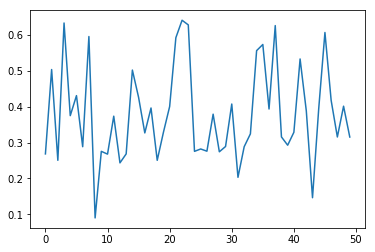

0.35126538647008265 0.017959182388131677
______NOOKS_________
DAY 4


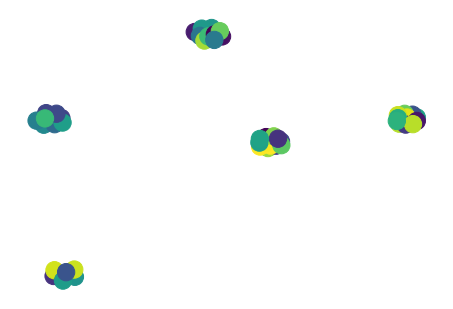

______NETWORK_________


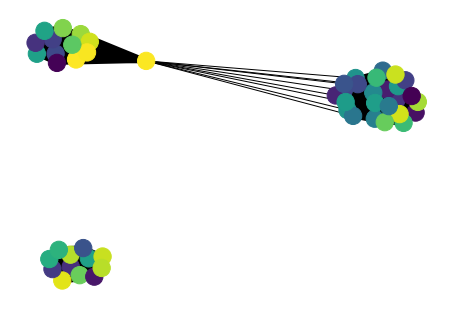

                        0         1
0    [0.5454701510335127]  0.197985
1   [0.17186531503221092]  0.503769
2    [0.8529318094853018]  0.250642
3    [0.1802234107934909]  0.576837
4    [0.5887000501236939]  0.375216
5   [0.12077490070210317]  0.431030
6    [0.5546987504607485]  0.288603
7   [0.08202617803816459]  0.662347
8    [0.9927051747471592]  0.090021
9   [0.25271926140483236]  0.591501
10   [0.5329600134943397]  0.196316
11   [0.8921390974896606]  0.373703
12   [0.2420936256921531]  0.243530
13    [0.417620739071376]  0.249125
14   [0.8679454838383429]  0.581162
15   [0.2863302410874564]  0.426169
16  [0.13769966369288933]  0.327045
17  [0.05079360233397934]  0.753042
18   [0.9282908716142158]  0.250642
19   [0.7799501422424319]  0.328828
20   [0.6944745088808787]  0.383100
21   [0.9534386673937157]  0.592546
22   [0.9319422792028977]  0.641231
23  [0.20739953724741955]  0.628278
24  [0.22335698243535906]  0.308356
25   [0.9975183649415177]  0.282254
26  [0.49206330478724125]  0

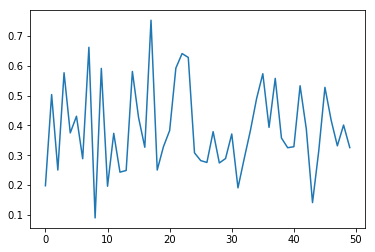

0.372616433332279 0.021188443403936427
______NOOKS_________
DAY 5


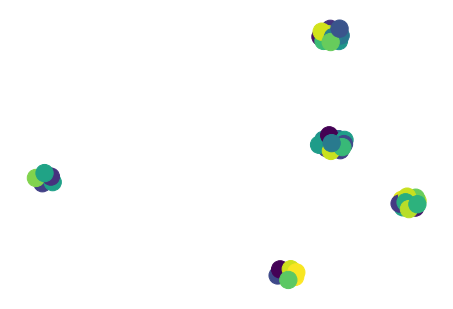

______NETWORK_________


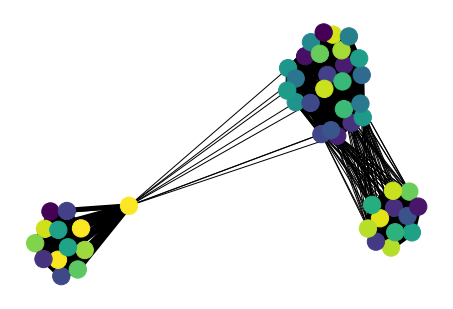

                        0         1
0    [0.5454701510335127]  0.197985
1   [0.17186531503221092]  0.503769
2    [0.8529318094853018]  0.250642
3    [0.1802234107934909]  0.531756
4    [0.5887000501236939]  0.375216
5   [0.12077490070210317]  0.431030
6    [0.5546987504607485]  0.288603
7   [0.08202617803816459]  0.680849
8    [0.9927051747471592]  0.090021
9   [0.25271926140483236]  0.591501
10   [0.5329600134943397]  0.283618
11   [0.8921390974896606]  0.373703
12   [0.2420936256921531]  0.243530
13    [0.417620739071376]  0.328888
14   [0.8679454838383429]  0.462299
15   [0.2863302410874564]  0.426169
16  [0.13769966369288933]  0.327045
17  [0.05079360233397934]  0.753042
18   [0.9282908716142158]  0.250642
19   [0.7799501422424319]  0.328828
20   [0.6944745088808787]  0.400637
21   [0.9534386673937157]  0.592546
22   [0.9319422792028977]  0.641231
23  [0.20739953724741955]  0.628278
24  [0.22335698243535906]  0.308356
25   [0.9975183649415177]  0.282254
26  [0.49206330478724125]  0

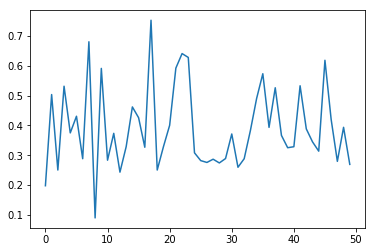

0.36911729374782465 0.01904087777651387
______NOOKS_________
DAY 6


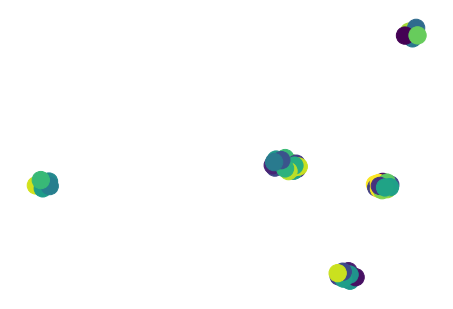

______NETWORK_________


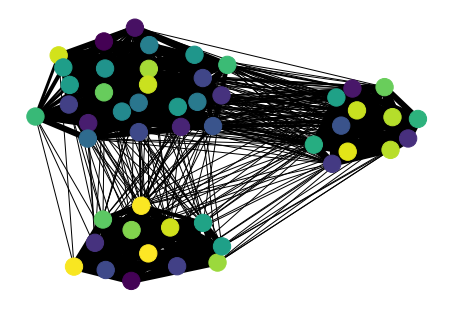

                        0         1
0    [0.5454701510335127]  0.252123
1   [0.17186531503221092]  0.624931
2    [0.8529318094853018]  0.250642
3    [0.1802234107934909]  0.479526
4    [0.5887000501236939]  0.375216
5   [0.12077490070210317]  0.431030
6    [0.5546987504607485]  0.324697
7   [0.08202617803816459]  0.595791
8    [0.9927051747471592]  0.090021
9   [0.25271926140483236]  0.591501
10   [0.5329600134943397]  0.283618
11   [0.8921390974896606]  0.402044
12   [0.2420936256921531]  0.241264
13    [0.417620739071376]  0.328888
14   [0.8679454838383429]  0.517669
15   [0.2863302410874564]  0.491860
16  [0.13769966369288933]  0.257290
17  [0.05079360233397934]  0.753042
18   [0.9282908716142158]  0.250642
19   [0.7799501422424319]  0.231489
20   [0.6944745088808787]  0.400637
21   [0.9534386673937157]  0.682178
22   [0.9319422792028977]  0.641231
23  [0.20739953724741955]  0.628278
24  [0.22335698243535906]  0.428676
25   [0.9975183649415177]  0.093871
26  [0.49206330478724125]  0

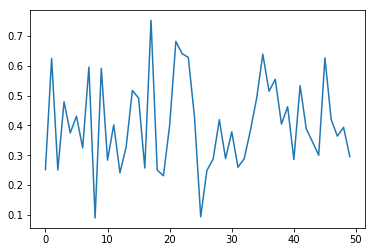

0.39124075253671475 0.022403297284840494
______NOOKS_________
DAY 7


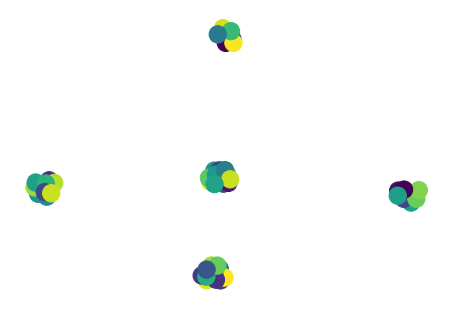

______NETWORK_________


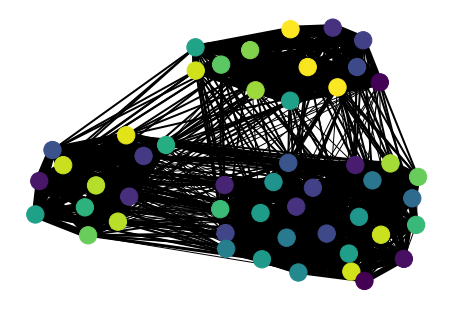

                        0         1
0    [0.5454701510335127]  0.297203
1   [0.17186531503221092]  0.624931
2    [0.8529318094853018]  0.289640
3    [0.1802234107934909]  0.479526
4    [0.5887000501236939]  0.375216
5   [0.12077490070210317]  0.467253
6    [0.5546987504607485]  0.312402
7   [0.08202617803816459]  0.555792
8    [0.9927051747471592]  0.392451
9   [0.25271926140483236]  0.591501
10   [0.5329600134943397]  0.280233
11   [0.8921390974896606]  0.380007
12   [0.2420936256921531]  0.241264
13    [0.417620739071376]  0.287094
14   [0.8679454838383429]  0.580179
15   [0.2863302410874564]  0.491860
16  [0.13769966369288933]  0.226516
17  [0.05079360233397934]  0.683900
18   [0.9282908716142158]  0.141485
19   [0.7799501422424319]  0.231489
20   [0.6944745088808787]  0.400637
21   [0.9534386673937157]  0.672778
22   [0.9319422792028977]  0.563340
23  [0.20739953724741955]  0.628278
24  [0.22335698243535906]  0.507901
25   [0.9975183649415177]  0.396302
26  [0.49206330478724125]  0

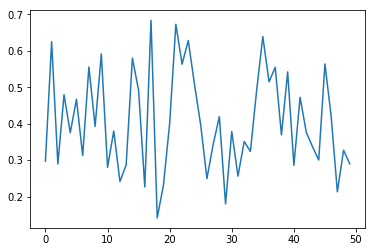

0.37933462307693755 0.019128323734961143
______NOOKS_________
DAY 8


______NETWORK_________


                        0         1
0    [0.5454701510335127]  0.297203
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.289640
3    [0.1802234107934909]  0.380301
4    [0.5887000501236939]  0.368163
5   [0.12077490070210317]  0.480297
6    [0.5546987504607485]  0.214122
7   [0.08202617803816459]  0.468867
8    [0.9927051747471592]  0.392451
9   [0.25271926140483236]  0.591501
10   [0.5329600134943397]  0.280233
11   [0.8921390974896606]  0.380007
12   [0.2420936256921531]  0.215485
13    [0.417620739071376]  0.287094
14   [0.8679454838383429]  0.538385
15   [0.2863302410874564]  0.491860
16  [0.13769966369288933]  0.266264
17  [0.05079360233397934]  0.683900
18   [0.9282908716142158]  0.141485
19   [0.7799501422424319]  0.243749
20   [0.6944745088808787]  0.400637
21   [0.9534386673937157]  0.612304
22   [0.9319422792028977]  0.563340
23  [0.20739953724741955]  0.628278
24  [0.22335698243535906]  0.507901
25   [0.9975183649415177]  0.396302
26  [0.49206330478724125]  0

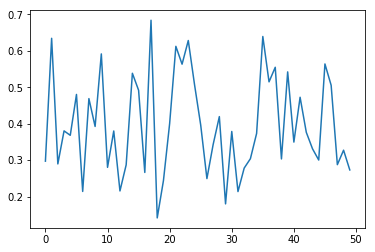

0.3774952351966107 0.01858133734586225
______NOOKS_________
DAY 9


______NETWORK_________


                        0         1
0    [0.5454701510335127]  0.262071
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.390414
3    [0.1802234107934909]  0.404256
4    [0.5887000501236939]  0.368163
5   [0.12077490070210317]  0.480297
6    [0.5546987504607485]  0.242588
7   [0.08202617803816459]  0.468867
8    [0.9927051747471592]  0.392451
9   [0.25271926140483236]  0.522360
10   [0.5329600134943397]  0.256789
11   [0.8921390974896606]  0.380007
12   [0.2420936256921531]  0.215485
13    [0.417620739071376]  0.271713
14   [0.8679454838383429]  0.472791
15   [0.2863302410874564]  0.491860
16  [0.13769966369288933]  0.266264
17  [0.05079360233397934]  0.683900
18   [0.9282908716142158]  0.141485
19   [0.7799501422424319]  0.351896
20   [0.6944745088808787]  0.444570
21   [0.9534386673937157]  0.612304
22   [0.9319422792028977]  0.589030
23  [0.20739953724741955]  0.628278
24  [0.22335698243535906]  0.507901
25   [0.9975183649415177]  0.396302
26  [0.49206330478724125]  0

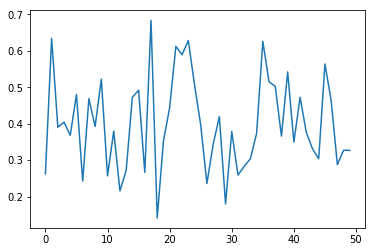

0.3793346230769375 0.016420415085074046
______NOOKS_________
DAY 10


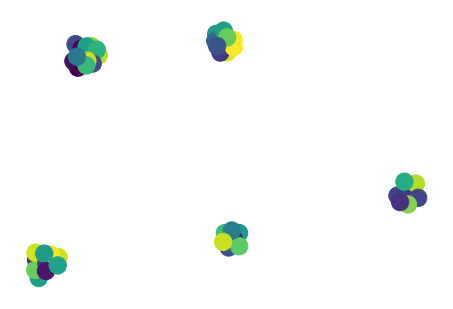

______NETWORK_________


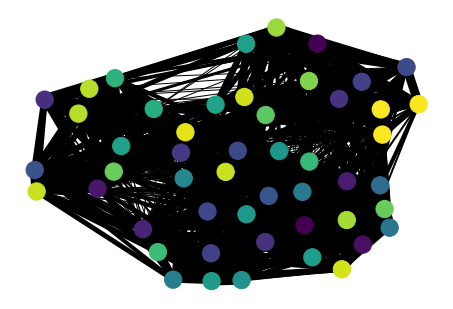

                        0         1
0    [0.5454701510335127]  0.262071
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.390414
3    [0.1802234107934909]  0.380301
4    [0.5887000501236939]  0.368163
5   [0.12077490070210317]  0.451230
6    [0.5546987504607485]  0.242588
7   [0.08202617803816459]  0.543560
8    [0.9927051747471592]  0.572633
9   [0.25271926140483236]  0.522360
10   [0.5329600134943397]  0.195405
11   [0.8921390974896606]  0.380007
12   [0.2420936256921531]  0.215485
13    [0.417620739071376]  0.255299
14   [0.8679454838383429]  0.472791
15   [0.2863302410874564]  0.516738
16  [0.13769966369288933]  0.266264
17  [0.05079360233397934]  0.683900
18   [0.9282908716142158]  0.141485
19   [0.7799501422424319]  0.414514
20   [0.6944745088808787]  0.396079
21   [0.9534386673937157]  0.612304
22   [0.9319422792028977]  0.693461
23  [0.20739953724741955]  0.567590
24  [0.22335698243535906]  0.507901
25   [0.9975183649415177]  0.403434
26  [0.49206330478724125]  0

0.3899735135707311 0.018926796480841085
______NOOKS_________
DAY 11


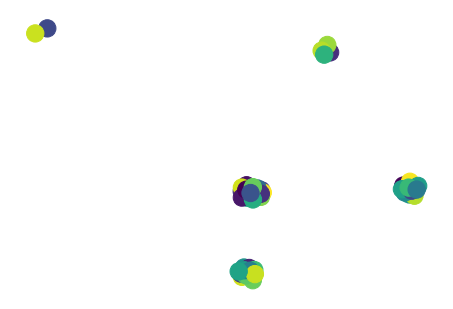

______NETWORK_________


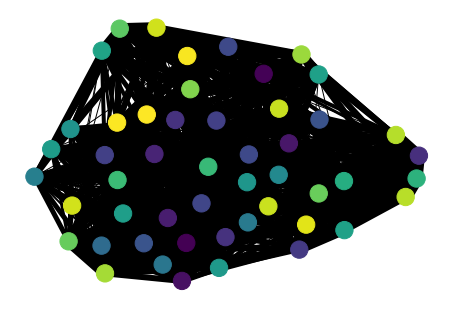

                        0         1
0    [0.5454701510335127]  0.262071
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.390414
3    [0.1802234107934909]  0.255131
4    [0.5887000501236939]  0.368163
5   [0.12077490070210317]  0.379846
6    [0.5546987504607485]  0.242588
7   [0.08202617803816459]  0.543560
8    [0.9927051747471592]  0.581788
9   [0.25271926140483236]  0.522360
10   [0.5329600134943397]  0.228731
11   [0.8921390974896606]  0.380007
12   [0.2420936256921531]  0.224641
13    [0.417620739071376]  0.320893
14   [0.8679454838383429]  0.472791
15   [0.2863302410874564]  0.516738
16  [0.13769966369288933]  0.449579
17  [0.05079360233397934]  0.529068
18   [0.9282908716142158]  0.141485
19   [0.7799501422424319]  0.414514
20   [0.6944745088808787]  0.299278
21   [0.9534386673937157]  0.612304
22   [0.9319422792028977]  0.589030
23  [0.20739953724741955]  0.567590
24  [0.22335698243535906]  0.507901
25   [0.9975183649415177]  0.403434
26  [0.49206330478724125]  0

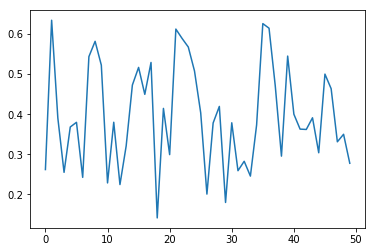

0.379926267003857 0.01643545265779893
______NOOKS_________
DAY 12


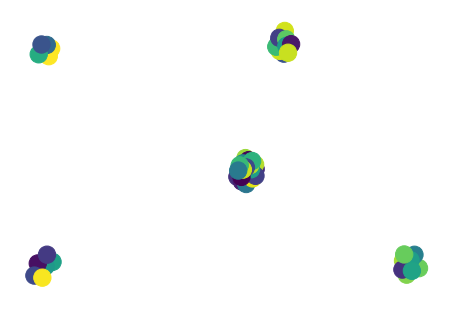

______NETWORK_________


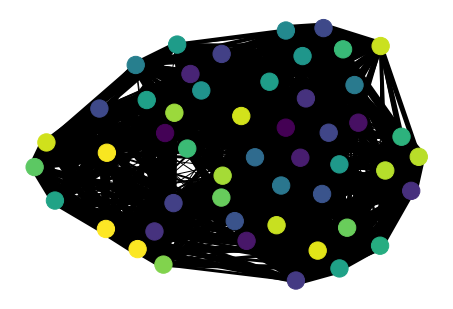

                        0         1
0    [0.5454701510335127]  0.197654
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.390414
3    [0.1802234107934909]  0.255131
4    [0.5887000501236939]  0.368163
5   [0.12077490070210317]  0.379846
6    [0.5546987504607485]  0.340783
7   [0.08202617803816459]  0.480911
8    [0.9927051747471592]  0.581788
9   [0.25271926140483236]  0.522360
10   [0.5329600134943397]  0.228731
11   [0.8921390974896606]  0.380007
12   [0.2420936256921531]  0.182413
13    [0.417620739071376]  0.320893
14   [0.8679454838383429]  0.472791
15   [0.2863302410874564]  0.499643
16  [0.13769966369288933]  0.356740
17  [0.05079360233397934]  0.621762
18   [0.9282908716142158]  0.200092
19   [0.7799501422424319]  0.344640
20   [0.6944745088808787]  0.299278
21   [0.9534386673937157]  0.612304
22   [0.9319422792028977]  0.693461
23  [0.20739953724741955]  0.567590
24  [0.22335698243535906]  0.507901
25   [0.9975183649415177]  0.480384
26  [0.49206330478724125]  0

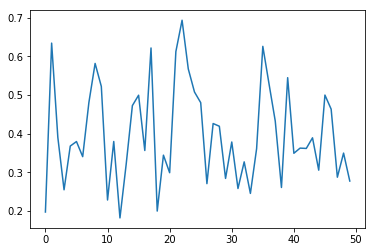

0.3734129430798735 0.016122346714424658
______NOOKS_________
DAY 13


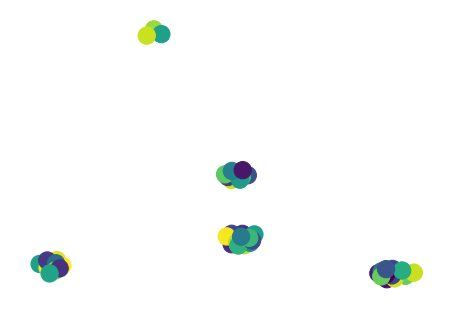

______NETWORK_________


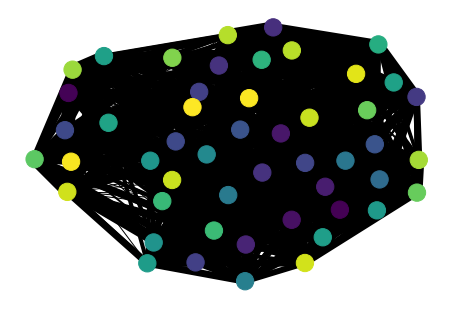

                        0         1
0    [0.5454701510335127]  0.241418
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.479723
3    [0.1802234107934909]  0.315806
4    [0.5887000501236939]  0.345271
5   [0.12077490070210317]  0.361165
6    [0.5546987504607485]  0.340783
7   [0.08202617803816459]  0.480911
8    [0.9927051747471592]  0.581788
9   [0.25271926140483236]  0.474174
10   [0.5329600134943397]  0.228731
11   [0.8921390974896606]  0.248062
12   [0.2420936256921531]  0.182413
13    [0.417620739071376]  0.320893
14   [0.8679454838383429]  0.472791
15   [0.2863302410874564]  0.378979
16  [0.13769966369288933]  0.356740
17  [0.05079360233397934]  0.621762
18   [0.9282908716142158]  0.200092
19   [0.7799501422424319]  0.243749
20   [0.6944745088808787]  0.299278
21   [0.9534386673937157]  0.612304
22   [0.9319422792028977]  0.602604
23  [0.20739953724741955]  0.567590
24  [0.22335698243535906]  0.507901
25   [0.9975183649415177]  0.480384
26  [0.49206330478724125]  0

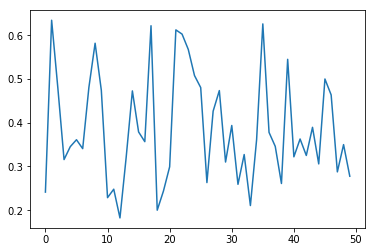

0.35895257727701557 0.015279425352892674
______NOOKS_________
DAY 14


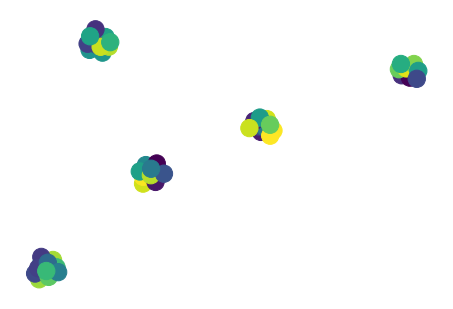

______NETWORK_________


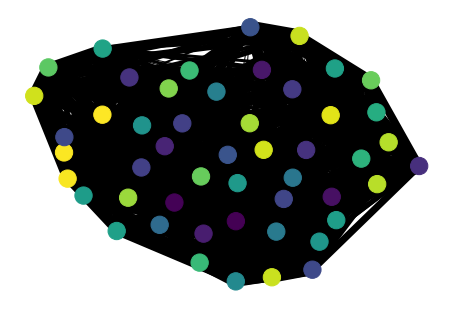

                        0         1
0    [0.5454701510335127]  0.286195
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.479723
3    [0.1802234107934909]  0.315806
4    [0.5887000501236939]  0.298169
5   [0.12077490070210317]  0.361165
6    [0.5546987504607485]  0.301267
7   [0.08202617803816459]  0.480911
8    [0.9927051747471592]  0.632002
9   [0.25271926140483236]  0.414074
10   [0.5329600134943397]  0.228731
11   [0.8921390974896606]  0.248062
12   [0.2420936256921531]  0.182413
13    [0.417620739071376]  0.320893
14   [0.8679454838383429]  0.489510
15   [0.2863302410874564]  0.415147
16  [0.13769966369288933]  0.314566
17  [0.05079360233397934]  0.535241
18   [0.9282908716142158]  0.350277
19   [0.7799501422424319]  0.250856
20   [0.6944745088808787]  0.299278
21   [0.9534386673937157]  0.476715
22   [0.9319422792028977]  0.527855
23  [0.20739953724741955]  0.557748
24  [0.22335698243535906]  0.561971
25   [0.9975183649415177]  0.544594
26  [0.49206330478724125]  0

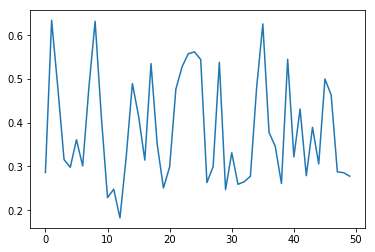

0.33872641470823417 0.014679396980881292
______NOOKS_________
DAY 15


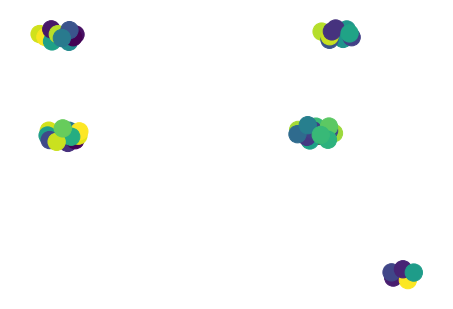

______NETWORK_________


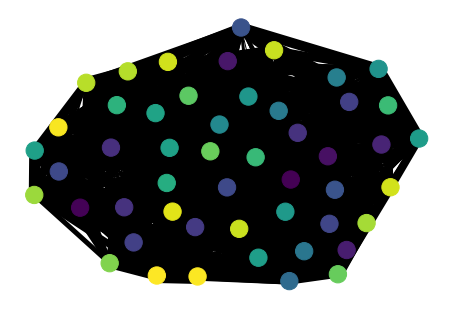

                        0         1
0    [0.5454701510335127]  0.233332
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.479723
3    [0.1802234107934909]  0.425506
4    [0.5887000501236939]  0.320392
5   [0.12077490070210317]  0.351385
6    [0.5546987504607485]  0.301267
7   [0.08202617803816459]  0.480911
8    [0.9927051747471592]  0.606676
9   [0.25271926140483236]  0.414074
10   [0.5329600134943397]  0.228731
11   [0.8921390974896606]  0.317937
12   [0.2420936256921531]  0.182413
13    [0.417620739071376]  0.281249
14   [0.8679454838383429]  0.489510
15   [0.2863302410874564]  0.407364
16  [0.13769966369288933]  0.314566
17  [0.05079360233397934]  0.535241
18   [0.9282908716142158]  0.346966
19   [0.7799501422424319]  0.250856
20   [0.6944745088808787]  0.299278
21   [0.9534386673937157]  0.476715
22   [0.9319422792028977]  0.527855
23  [0.20739953724741955]  0.476126
24  [0.22335698243535906]  0.413974
25   [0.9975183649415177]  0.544594
26  [0.49206330478724125]  0

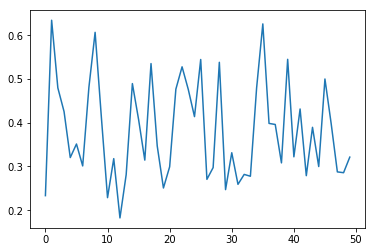

0.349175256044163 0.012821327063148959
______NOOKS_________
DAY 16


______NETWORK_________


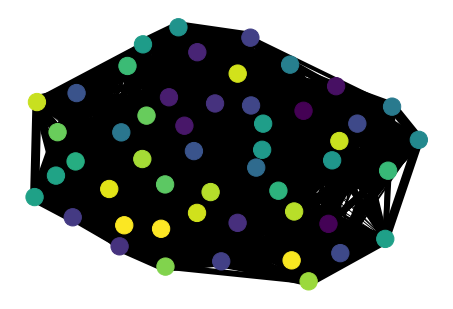

                        0         1
0    [0.5454701510335127]  0.233332
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.479723
3    [0.1802234107934909]  0.295497
4    [0.5887000501236939]  0.325610
5   [0.12077490070210317]  0.351385
6    [0.5546987504607485]  0.317986
7   [0.08202617803816459]  0.428170
8    [0.9927051747471592]  0.606676
9   [0.25271926140483236]  0.414074
10   [0.5329600134943397]  0.228731
11   [0.8921390974896606]  0.317937
12   [0.2420936256921531]  0.253228
13    [0.417620739071376]  0.281249
14   [0.8679454838383429]  0.402725
15   [0.2863302410874564]  0.415147
16  [0.13769966369288933]  0.314566
17  [0.05079360233397934]  0.537202
18   [0.9282908716142158]  0.346966
19   [0.7799501422424319]  0.250856
20   [0.6944745088808787]  0.299278
21   [0.9534386673937157]  0.476715
22   [0.9319422792028977]  0.527855
23  [0.20739953724741955]  0.476126
24  [0.22335698243535906]  0.413974
25   [0.9975183649415177]  0.544594
26  [0.49206330478724125]  0

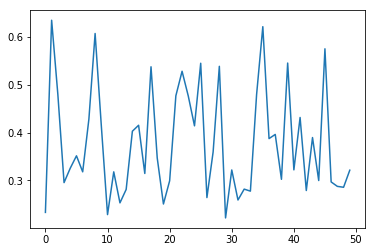

0.3362878459436989 0.012674876678511445
______NOOKS_________
DAY 17


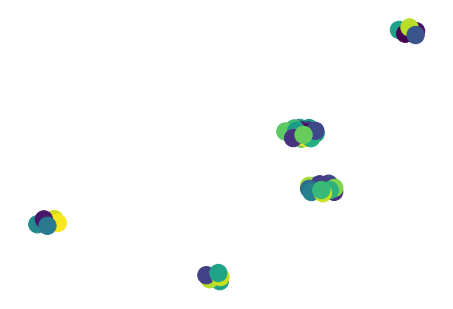

______NETWORK_________


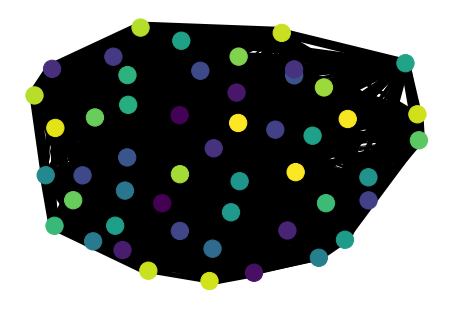

                        0         1
0    [0.5454701510335127]  0.233332
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.479723
3    [0.1802234107934909]  0.425506
4    [0.5887000501236939]  0.288959
5   [0.12077490070210317]  0.351385
6    [0.5546987504607485]  0.281891
7   [0.08202617803816459]  0.470805
8    [0.9927051747471592]  0.606676
9   [0.25271926140483236]  0.414074
10   [0.5329600134943397]  0.228731
11   [0.8921390974896606]  0.266109
12   [0.2420936256921531]  0.253228
13    [0.417620739071376]  0.370940
14   [0.8679454838383429]  0.402725
15   [0.2863302410874564]  0.415147
16  [0.13769966369288933]  0.314566
17  [0.05079360233397934]  0.537202
18   [0.9282908716142158]  0.346966
19   [0.7799501422424319]  0.250856
20   [0.6944745088808787]  0.299278
21   [0.9534386673937157]  0.476715
22   [0.9319422792028977]  0.527855
23  [0.20739953724741955]  0.476126
24  [0.22335698243535906]  0.413974
25   [0.9975183649415177]  0.398577
26  [0.49206330478724125]  0

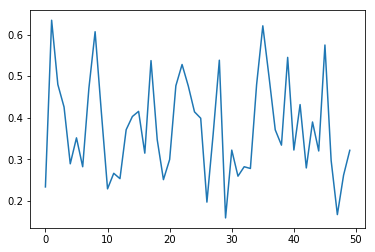

0.3554621422740415 0.014214713495260765
______NOOKS_________
DAY 18


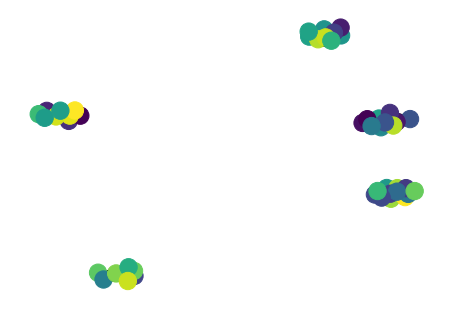

______NETWORK_________


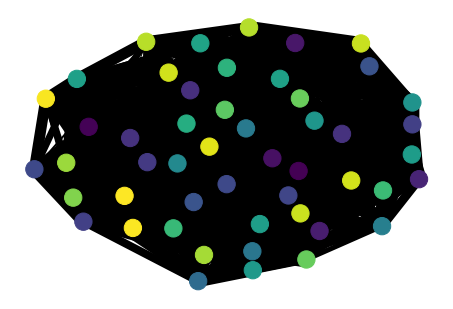

                        0         1
0    [0.5454701510335127]  0.225152
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.493675
3    [0.1802234107934909]  0.353670
4    [0.5887000501236939]  0.288959
5   [0.12077490070210317]  0.351385
6    [0.5546987504607485]  0.321733
7   [0.08202617803816459]  0.470805
8    [0.9927051747471592]  0.615832
9   [0.25271926140483236]  0.414074
10   [0.5329600134943397]  0.228731
11   [0.8921390974896606]  0.266109
12   [0.2420936256921531]  0.211526
13    [0.417620739071376]  0.374688
14   [0.8679454838383429]  0.402725
15   [0.2863302410874564]  0.393992
16  [0.13769966369288933]  0.420730
17  [0.05079360233397934]  0.684201
18   [0.9282908716142158]  0.346966
19   [0.7799501422424319]  0.253686
20   [0.6944745088808787]  0.230073
21   [0.9534386673937157]  0.476715
22   [0.9319422792028977]  0.496469
23  [0.20739953724741955]  0.476126
24  [0.22335698243535906]  0.413974
25   [0.9975183649415177]  0.398577
26  [0.49206330478724125]  0

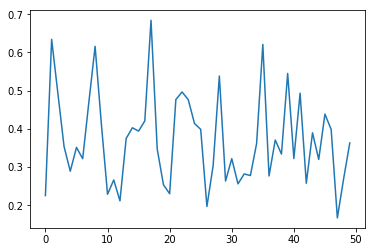

0.35754085141035863 0.014429216479745887
______NOOKS_________
DAY 19


______NETWORK_________


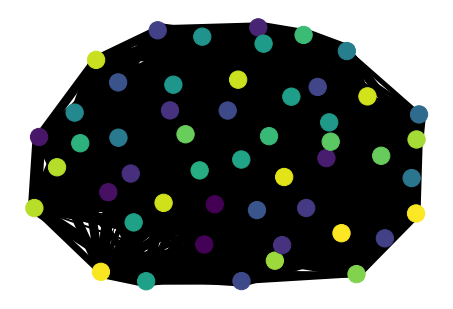

                        0         1
0    [0.5454701510335127]  0.225152
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.493675
3    [0.1802234107934909]  0.364818
4    [0.5887000501236939]  0.288959
5   [0.12077490070210317]  0.351385
6    [0.5546987504607485]  0.321733
7   [0.08202617803816459]  0.470805
8    [0.9927051747471592]  0.357141
9   [0.25271926140483236]  0.414074
10   [0.5329600134943397]  0.228731
11   [0.8921390974896606]  0.317937
12   [0.2420936256921531]  0.283992
13    [0.417620739071376]  0.438699
14   [0.8679454838383429]  0.402725
15   [0.2863302410874564]  0.415147
16  [0.13769966369288933]  0.420730
17  [0.05079360233397934]  0.684201
18   [0.9282908716142158]  0.346966
19   [0.7799501422424319]  0.320177
20   [0.6944745088808787]  0.230073
21   [0.9534386673937157]  0.476715
22   [0.9319422792028977]  0.496469
23  [0.20739953724741955]  0.476126
24  [0.22335698243535906]  0.325410
25   [0.9975183649415177]  0.398577
26  [0.49206330478724125]  0

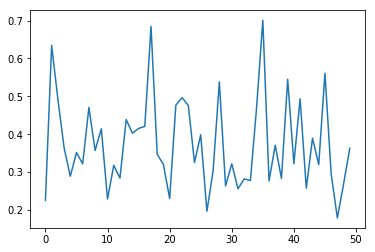

0.349175256044163 0.014475858762662578
______NOOKS_________
DAY 20


______NETWORK_________


                        0         1
0    [0.5454701510335127]  0.225152
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.493675
3    [0.1802234107934909]  0.425506
4    [0.5887000501236939]  0.288959
5   [0.12077490070210317]  0.439949
6    [0.5546987504607485]  0.278700
7   [0.08202617803816459]  0.371674
8    [0.9927051747471592]  0.606676
9   [0.25271926140483236]  0.414074
10   [0.5329600134943397]  0.228731
11   [0.8921390974896606]  0.248062
12   [0.2420936256921531]  0.283992
13    [0.417620739071376]  0.442999
14   [0.8679454838383429]  0.402725
15   [0.2863302410874564]  0.466939
16  [0.13769966369288933]  0.420730
17  [0.05079360233397934]  0.684201
18   [0.9282908716142158]  0.346966
19   [0.7799501422424319]  0.320177
20   [0.6944745088808787]  0.230073
21   [0.9534386673937157]  0.537189
22   [0.9319422792028977]  0.373979
23  [0.20739953724741955]  0.476126
24  [0.22335698243535906]  0.449061
25   [0.9975183649415177]  0.683892
26  [0.49206330478724125]  0

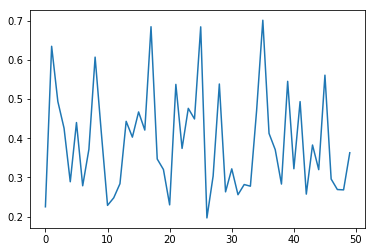

0.3711962359228721 0.017042938341594562
______NOOKS_________
DAY 21


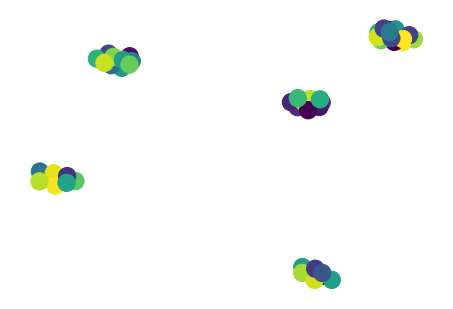

______NETWORK_________


                        0         1
0    [0.5454701510335127]  0.225152
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.488410
3    [0.1802234107934909]  0.425506
4    [0.5887000501236939]  0.325610
5   [0.12077490070210317]  0.564121
6    [0.5546987504607485]  0.278700
7   [0.08202617803816459]  0.371674
8    [0.9927051747471592]  0.545555
9   [0.25271926140483236]  0.426209
10   [0.5329600134943397]  0.228731
11   [0.8921390974896606]  0.248062
12   [0.2420936256921531]  0.305262
13    [0.417620739071376]  0.442999
14   [0.8679454838383429]  0.402725
15   [0.2863302410874564]  0.439830
16  [0.13769966369288933]  0.420730
17  [0.05079360233397934]  0.685199
18   [0.9282908716142158]  0.346966
19   [0.7799501422424319]  0.320177
20   [0.6944745088808787]  0.265143
21   [0.9534386673937157]  0.537189
22   [0.9319422792028977]  0.373979
23  [0.20739953724741955]  0.476126
24  [0.22335698243535906]  0.449061
25   [0.9975183649415177]  0.683892
26  [0.49206330478724125]  0

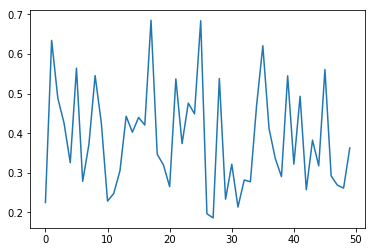

0.3673075955580391 0.01698920238624544
______NOOKS_________
DAY 22


______NETWORK_________


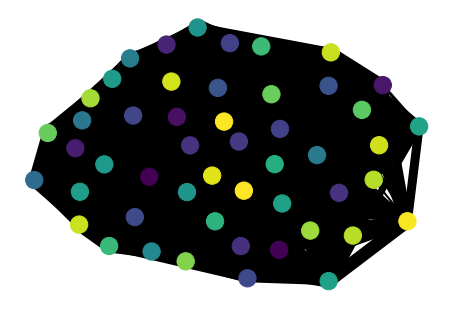

                        0         1
0    [0.5454701510335127]  0.225152
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.488410
3    [0.1802234107934909]  0.498091
4    [0.5887000501236939]  0.313350
5   [0.12077490070210317]  0.531442
6    [0.5546987504607485]  0.278700
7   [0.08202617803816459]  0.340194
8    [0.9927051747471592]  0.545555
9   [0.25271926140483236]  0.426209
10   [0.5329600134943397]  0.228731
11   [0.8921390974896606]  0.308349
12   [0.2420936256921531]  0.369405
13    [0.417620739071376]  0.442999
14   [0.8679454838383429]  0.402725
15   [0.2863302410874564]  0.467340
16  [0.13769966369288933]  0.420730
17  [0.05079360233397934]  0.685199
18   [0.9282908716142158]  0.346966
19   [0.7799501422424319]  0.320177
20   [0.6944745088808787]  0.265143
21   [0.9534386673937157]  0.537189
22   [0.9319422792028977]  0.440470
23  [0.20739953724741955]  0.476126
24  [0.22335698243535906]  0.449061
25   [0.9975183649415177]  0.683892
26  [0.49206330478724125]  0

0.3699528883877635 0.015515653521389663
______NOOKS_________
DAY 23


______NETWORK_________


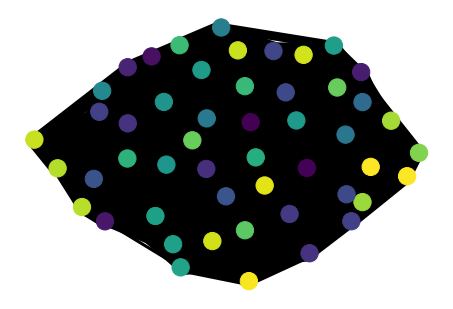

                        0         1
0    [0.5454701510335127]  0.299196
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.488410
3    [0.1802234107934909]  0.594858
4    [0.5887000501236939]  0.276485
5   [0.12077490070210317]  0.531442
6    [0.5546987504607485]  0.278700
7   [0.08202617803816459]  0.340194
8    [0.9927051747471592]  0.545555
9   [0.25271926140483236]  0.426209
10   [0.5329600134943397]  0.232116
11   [0.8921390974896606]  0.399445
12   [0.2420936256921531]  0.369405
13    [0.417620739071376]  0.442999
14   [0.8679454838383429]  0.402725
15   [0.2863302410874564]  0.467340
16  [0.13769966369288933]  0.452843
17  [0.05079360233397934]  0.685199
18   [0.9282908716142158]  0.409016
19   [0.7799501422424319]  0.323134
20   [0.6944745088808787]  0.333194
21   [0.9534386673937157]  0.537189
22   [0.9319422792028977]  0.440470
23  [0.20739953724741955]  0.476126
24  [0.22335698243535906]  0.449061
25   [0.9975183649415177]  0.683892
26  [0.49206330478724125]  0

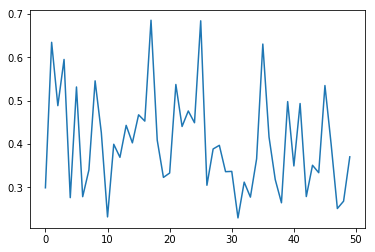

0.3928146035534808 0.013417108799385886
______NOOKS_________
DAY 24


______NETWORK_________


                        0         1
0    [0.5454701510335127]  0.299196
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.463257
3    [0.1802234107934909]  0.588058
4    [0.5887000501236939]  0.276485
5   [0.12077490070210317]  0.531442
6    [0.5546987504607485]  0.287326
7   [0.08202617803816459]  0.340194
8    [0.9927051747471592]  0.545555
9   [0.25271926140483236]  0.426209
10   [0.5329600134943397]  0.281250
11   [0.8921390974896606]  0.399445
12   [0.2420936256921531]  0.293110
13    [0.417620739071376]  0.353552
14   [0.8679454838383429]  0.402725
15   [0.2863302410874564]  0.524528
16  [0.13769966369288933]  0.420730
17  [0.05079360233397934]  0.685199
18   [0.9282908716142158]  0.409016
19   [0.7799501422424319]  0.323134
20   [0.6944745088808787]  0.333194
21   [0.9534386673937157]  0.609655
22   [0.9319422792028977]  0.389851
23  [0.20739953724741955]  0.476126
24  [0.22335698243535906]  0.477701
25   [0.9975183649415177]  0.683892
26  [0.49206330478724125]  0

0.3945851935254243 0.015728105519300584
______NOOKS_________
DAY 25


______NETWORK_________


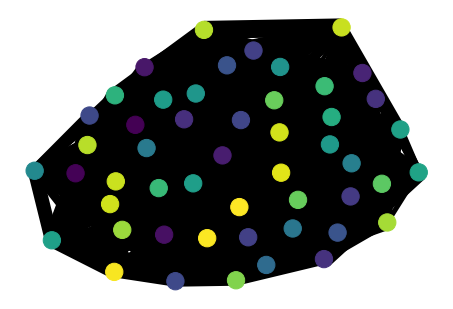

                        0         1
0    [0.5454701510335127]  0.240084
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.463257
3    [0.1802234107934909]  0.588058
4    [0.5887000501236939]  0.276485
5   [0.12077490070210317]  0.483126
6    [0.5546987504607485]  0.287326
7   [0.08202617803816459]  0.396905
8    [0.9927051747471592]  0.545555
9   [0.25271926140483236]  0.466392
10   [0.5329600134943397]  0.281250
11   [0.8921390974896606]  0.399445
12   [0.2420936256921531]  0.293110
13    [0.417620739071376]  0.353552
14   [0.8679454838383429]  0.455466
15   [0.2863302410874564]  0.524528
16  [0.13769966369288933]  0.497569
17  [0.05079360233397934]  0.685199
18   [0.9282908716142158]  0.353076
19   [0.7799501422424319]  0.323134
20   [0.6944745088808787]  0.333194
21   [0.9534386673937157]  0.609655
22   [0.9319422792028977]  0.465274
23  [0.20739953724741955]  0.476126
24  [0.22335698243535906]  0.475002
25   [0.9975183649415177]  0.549406
26  [0.49206330478724125]  0

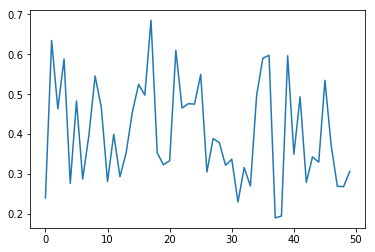

0.37546775372112096 0.015779147237861117
______NOOKS_________
DAY 26


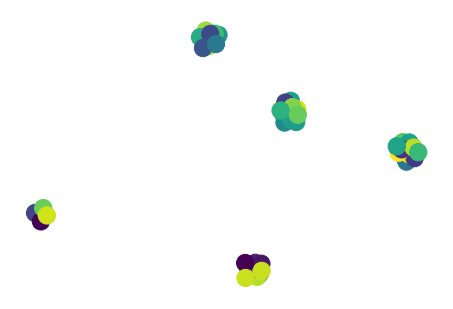

______NETWORK_________


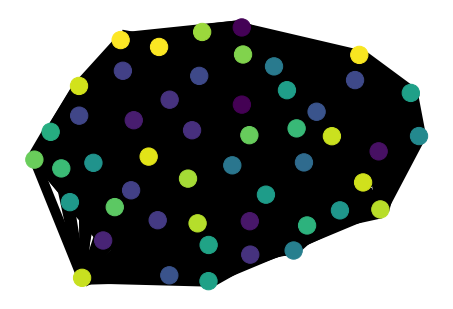

                        0         1
0    [0.5454701510335127]  0.240084
1   [0.17186531503221092]  0.634331
2    [0.8529318094853018]  0.463257
3    [0.1802234107934909]  0.588058
4    [0.5887000501236939]  0.288745
5   [0.12077490070210317]  0.483126
6    [0.5546987504607485]  0.327169
7   [0.08202617803816459]  0.396905
8    [0.9927051747471592]  0.545555
9   [0.25271926140483236]  0.466392
10   [0.5329600134943397]  0.281250
11   [0.8921390974896606]  0.399445
12   [0.2420936256921531]  0.293110
13    [0.417620739071376]  0.409199
14   [0.8679454838383429]  0.455466
15   [0.2863302410874564]  0.524528
16  [0.13769966369288933]  0.497569
17  [0.05079360233397934]  0.613354
18   [0.9282908716142158]  0.353076
19   [0.7799501422424319]  0.323134
20   [0.6944745088808787]  0.333194
21   [0.9534386673937157]  0.609655
22   [0.9319422792028977]  0.465274
23  [0.20739953724741955]  0.476126
24  [0.22335698243535906]  0.475002
25   [0.9975183649415177]  0.549406
26  [0.49206330478724125]  0

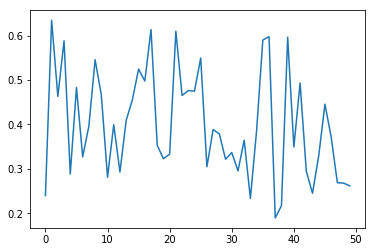

0.38262284346997055 0.014439763920788383
______NOOKS_________
DAY 27


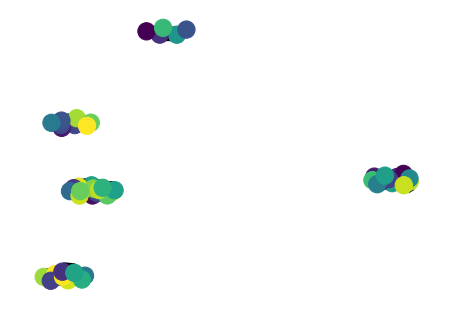

In [39]:
# control case
np.random.seed(SEED)
member_vectors = np.random.random(size=(50, 1))
#print(sorted(member_vectors))
exp = NooksExperiment(member_vectors, alpha=0, swipe_mode='all')
exp.run(num_nooks=5)